## Libraries

In [1]:
%load_ext autoreload
%autoreload 2.0
%matplotlib inline

In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import tensorflow as tf

/home/injy/mariam_workspace/env/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/injy/mariam_workspace/env/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/injy/mariam_workspace/env/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/injy/mariam_workspace/env/lib/python3.5/site-pack

In [3]:
import glob
# import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
import numpy as np
# import tensorflow as tf

In [4]:
# tf.__version__

In [5]:
import sys
sys.path.insert(0, '../.')

In [6]:
from data.segmentation_dataset_loader import *
from data.detection_dataset_loader import *
from model import *
# from Trainer import *
from evaluation.evaluate import *

In [7]:
tf.__version__

'1.14.0'

In [8]:
from data.postprocessing.nms import *

In [9]:
# params = {
#     'fusion': False
# }
# model = Model(graph=None, **params)

In [10]:
# model.cnn.res_groups

In [11]:
# model.cnn_lidar.res_groups

In [12]:
# with model.graph.as_default():
#     fusion_only_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,
#                                             "fusion")

In [13]:
# fuse_ops = tf.train.AdamOptimizer(1e-3).minimize(model.model_loss, var_list=fusion_only_vars, global_step=model.global_step)

In [14]:
# fusion_only_vars

In [15]:
# !cat ~/mariam_workspace/env3/lib/python3.5/site-packages/tensorflow/python/ops/state_ops.py 

In [16]:
# params = {
#     'fusion': True
# }
# model = Model(graph=None, **params)

## Utils

In [9]:
def prepare_dataset_feed_dict(model, dataset, train_fusion_rgb, train_fusion_fv_lidar, anchor_values, use_nms, is_training=False):
        # camera_tensor, lidar_tensor, fv_velo_tensor, label_tensor, Tr_velo_to_cam, R0_rect, P3, shift_h, shift_w = sess.run(dataset)
        data = list(dataset.get_next(batch_size=1))
#         data = list(next(dataset))

#         for i in range(len(data)):
#             data[i] = np.expand_dims(data[i], axis=0)
        camera_tensor, lidar_tensor, label_tensor, label_up_tensor, label_down_tensor, label_left_tensor, label_right_tensor, Tr_velo_to_cam, R0_rect, P3, shift_h, shift_w = data
#         print(np.max(camera_tensor))
        d = {model.train_inputs_rgb: camera_tensor,
                model.train_inputs_lidar: lidar_tensor,
                model.y_true: label_tensor,
                model.y_true_up: label_up_tensor,
                model.y_true_down: label_down_tensor,
                model.y_true_left: label_left_tensor,
                model.y_true_right: label_right_tensor,
                model.Tr_velo_to_cam: Tr_velo_to_cam,
                model.R0_rect: R0_rect,
                model.P3: P3,
                model.shift_h: shift_h,
                model.shift_w: shift_w,
                model.anchors: anchor_values,
                model.use_nms: use_nms,
                model.train_fusion_rgb: train_fusion_rgb,
                model.is_training: False}
        return d

In [10]:
def sigmoid(x):
    x = x.astype(np.float128)
    x = 1 / (1 + np.exp(-x))
    x = x.astype(np.float32)
    return x

def convert_prediction_into_real_values(label_tensor, truth_value=None,
            anchors=np.array([3.9, 1.6, 1.5]), 
            input_size=(512, 448), output_size=(128, 112), is_label=False, th=0.5):

    ratio = input_size[0] // output_size[0]
    result = []
    ones_index = np.where(sigmoid(label_tensor[:, :, :, -1])>=th)
    if truth_value is not None:
        ones_index = np.where(truth_value[:, :, :, -1]>=th)
#     print(ones_index)
    if len(ones_index) > 0 and len(ones_index[0]) > 0:
        for i in range(0, len(ones_index[0]), 1):
            x = ones_index[0][i]
            y = ones_index[1][i]
            
            out = np.copy(label_tensor[ones_index[0][i], ones_index[1][i], ones_index[2][i], :])
            anchor = np.array([x+0.5, y+0.5, 0.5, anchors[0], anchors[1], anchors[2]])
#             if not is_label:
#               out[:3] = sigmoid(out[:3])
#             if not is_label:
#                 out[:3] = 2 * sigmoid(out[:3]) - 1
            out[:3] = np.tanh(out[:3])*0.5 * anchor[3:6] + anchor[:3]
            
            out[:2] = out[:2] * ratio
            out[2] = out[2] * 40
            
            out[3:6] = np.exp(np.maximum(0, out[3:6])) * anchors
            
            k = ones_index[2][i]
            if not is_label:
              out[6] = sigmoid(out[6]) * np.pi/2 - np.pi/4
            if k == 0 and out[6] < 0:
                out[6] = out[6] + np.pi
                
            out[6] = out[6] + k * (np.pi/2)
                        
            result.append(out)
            
    return np.array(result)

In [11]:
import numpy as np
from PIL import Image, ImageDraw
import math
import numpy.matlib as npm

def convert5Pointto8Point(cx_, cy_, w_, h_, a_):

    theta = math.radians(a_)
    bbox = npm.repmat([[cx_], [cy_]], 1, 5) + \
       np.matmul([[math.cos(theta), math.sin(theta)],
                  [-math.sin(theta), math.cos(theta)]],
                 [[-w_ / 2, w_/ 2, w_ / 2, -w_ / 2, w_ / 2 + 8],
                  [-h_ / 2, -h_ / 2, h_ / 2, h_ / 2, 0]])
    # add first point
    x1, y1 = bbox[0][0], bbox[1][0]
    # add second point
    x2, y2 = bbox[0][1], bbox[1][1]
    # add third point
    #x3, y3 = bbox[0][4], bbox[1][4]   
    # add forth point
    x3, y3 = bbox[0][2], bbox[1][2]
    # add fifth point
    x4, y4 = bbox[0][3], bbox[1][3]

    return [x1, y1, x2, y2, x3, y3, x4, y4]

In [12]:
def get_points(converted_points, calib_path, 
                x_range=(0, 71), y_range=(-40, 40), z_range=(-3.0, 1), 
                size=(512, 448, 40), th=0.5):
    all_result = []
    for converted_points_ in converted_points:
        if sigmoid(converted_points_[-1]) >= th:
            result = [0] * 16
            result[0] = 'Car'
            result[1] = -1
            result[2] = -1
            result[3] = -10
            result[8] = converted_points_[5]
            result[9] = converted_points_[4]
            result[10] = converted_points_[3]
            result[14] = converted_points_[6]
            result[15] = sigmoid(converted_points_[-1])

            calib_data = read_calib(calib_path)

            # x_range=(0, 70)
            # y_range=(-40, 40)
            # z_range=(-2.5, 1)

            x_size = (x_range[1] - x_range[0])
            y_size = (y_range[1] - y_range[0])
            z_size = (z_range[1] - z_range[0])

            x_fac = (size[0]-1) / x_size
            y_fac = (size[1]-1) / y_size
            z_fac = (size[2]-1) / z_size

            x, y, z = -((converted_points_[:3] - size) / np.array([x_fac, y_fac, z_fac])) - np.array([0, -1*y_range[0], -1*z_range[0]]) 
            point = np.array([[x, y, z]])
            box3d_pts_3d = point

            pts_3d_ref = project_velo_to_ref(box3d_pts_3d, calib_data['Tr_velo_to_cam'].reshape((3, 4)))
            pts_3d_ref = project_ref_to_rect(pts_3d_ref, calib_data['R0_rect'].reshape((3, 3)))[0]
            for k in range(3):
                result[11 + k] = pts_3d_ref[k]

            imgbbox = ProjectTo2Dbbox(pts_3d_ref, converted_points_[5], converted_points_[4],
                         converted_points_[3], converted_points_[6], calib_data['P2'].reshape((3, 4)))

            result[4:8] = imgbbox
            all_result.append(result)
    return all_result

## Model

In [13]:
# tf.convert_to_tensor

In [14]:
# params = {
#     'fusion': True
# }
# model = Model(graph=None, **params)

In [15]:
# gg = model.cnn_lidar.res_groups2[-1]

In [23]:
# gg.consumers()

In [19]:
# gg.consumers()

In [20]:
# Tensor("lidar_branch/network_lidar/resblock1_3/Relu_1:0", shape=(?, 256, 224, 64), dtype=float32)
# Tensor("lidar_branch/network_lidar/resblock1_3/Relu_1:0", shape=(?, 256, 224, 64), dtype=float32)


In [21]:
# Tensor("lidar_branch/network_lidar/resblock3_11/Relu_1:0", shape=(?, 64, 56, 256), dtype=float32)
# Tensor("fusion/cond_5/Merge:0", shape=(?, 64, 56, 256), dtype=float32)


In [22]:
# old_vars = model.lidar_only_vars

In [23]:
# new_vars = model.lidar_only_vars

In [24]:
# fusion_vars = model.fusion_only_vars

In [25]:
# len(old_vars)

In [26]:
# len(new_vars)

In [27]:
# len(fusion_vars)

In [28]:
# model.fusion_only_vars

In [35]:
# old_lidar_only_vars = model.lidar_only_vars

In [36]:
# new_lidar_only_vars = new_model.lidar_only_vars

In [37]:
# old_names = [var.name.replace('lidar_branch/', '').replace('lidar_branch_1/', '') for var in old_lidar_only_vars]
# new_names = [var.name.replace('lidar_branch/fpn/', '').replace('lidar_branch/', '').replace('lidar_branch_1/fpn/', '').replace('lidar_branch_1/', '') for var in new_lidar_only_vars]

In [38]:
# len(old_names), len(new_names)

In [39]:
# for name in new_names:
#     if name not in old_names:
#         print(name)

In [40]:
# for name in old_names:
#     if name not in new_names:
#         print(name)

## Evaluation

In [41]:
# from tensorflow.python.framework.ops import get_gradient_function

# a = tf.add(1, 2, name="Add_these_numbers")
# b = tf.multiply(a, 3, name='mult')
# c = tf.reduce_sum(a, name='s')

# mult = tf.get_default_graph().get_operation_by_name('s')
# print(get_gradient_function(mult))  # <function _MulGrad at 0x7fa29950dc80>

# g = tf.greater_equal(a, 3, name='ge1')
# stop = tf.get_default_graph().get_operation_by_name('ge1')
# print(get_gradient_function(stop))  # None

In [42]:
# dataset = DetectionDatasetLoader(base_path='../../../Data', batch_size=4, random_seed=0, training=True)
# temp = dataset.get_next(batch_size=4)

In [43]:
# temp = dataset.get_next(batch_size=4)

In [44]:
# temp[0].shape

In [45]:
# np.max(temp[1])

In [16]:
def read_label2(label_path, calib_path, shift_h, shift_w, x_range=(0, 71), y_range=(-40, 40), z_range=(-3.0, 1), 
                    size=(512, 448, 40), get_actual_dims=False, from_file=True, translate_x=0, translate_y=0, translate_z=0, ang=0, get_neg=False):

    """
    the file format is as follows: 
    type, truncated, occluded, alpha, bbox_left, bbox_top, bbox_right, bbox_bottom,
    dimensions_height, dimensions_width, dimensions_length, location_x, location_y, location_z,
    rotation_y, score) 
    """
    if from_file:
        lines = []
        with open(label_path, 'r') as label_file:
            lines = label_file.readlines()
    else:
        lines = label_path.split('\n')
    # filter car class
    lines = list(map(lambda x: x.split(), lines))
    if len(lines) > 0:
        if get_neg:
            lines = list(filter(lambda x: len(x) > 0 and ( x[0] not in ['Car', 'Van', 'Truck', 'Tram', 'DontCare']), lines))
            if len(lines) > 0:
                lines = lines[:1]
        else:
            lines = list(filter(lambda x: len(x) > 0 and ( x[0] in ['Car']), lines))
    
    def get_parameter(index):
        return list(map(lambda x: x[index], lines))
    
    classes = np.array(get_parameter(0))
    dimension_height = np.array(get_parameter(8)).astype(float)
    dimension_width = np.array(get_parameter(9)).astype(float)
    dimension_length = np.array(get_parameter(10)).astype(float)
    # TODO: take shift into consideration - URGENT
    location_x = np.array(get_parameter(11)).astype(float)
    location_y = np.array(get_parameter(12)).astype(float)
    location_z = np.array(get_parameter(13)).astype(float)
    angles = np.array(get_parameter(14)).astype(float)
    
    # print(len(classes))
    calib_data = read_calib(calib_path)

    locations = np.array([[location_x[i], location_y[i], location_z[i]] for i in range(len(classes))])
    # print(locations)
    if len(locations) > 0 and len(locations[0]) > 0:
        locations = project_rect_to_velo(locations, calib_data['R0_rect'].reshape((3, 3)), calib_data['Tr_velo_to_cam'].reshape((3, 4)))
    # print(locations)
    # print(z_range)
    locations = np.array(list(filter(lambda point: (point[0] >= x_range[0]  and point[0] <= x_range[1])
                                    and (point[1] >= y_range[0] and point[1] <= y_range[1])
                                    and (point[2] >= z_range[0] and point[2] <= z_range[1]) , locations)))

    indx = []
    i = 0
    for point in locations:
        if (point[0] >= x_range[0]  and point[0] <= x_range[1])\
            and (point[1] >= y_range[0] and point[1] <= y_range[1])\
            and (point[2] >= z_range[0] and point[2] <= z_range[1]):
            indx.append(i)
        i += 1

    if len(indx) > 0:
        dimension_height = dimension_height[indx]
        dimension_width = dimension_width[indx]
        dimension_length = dimension_length[indx]
        location_x = location_x[indx]
        location_y = location_y[indx]
        location_z = location_z[indx]
        angles = angles[indx]
        classes = classes[indx]

    if len(locations) > 0:
        locations[:, :3] = locations[:, :3] - np.array([translate_x, translate_y, -translate_z])

    # print('.......')
    # print(len(locations))

    points = [project_point_from_camera_coor_to_velo_coor([location_x[i], location_y[i], location_z[i]], 
                                                        [dimension_height[i], dimension_width[i], dimension_length[i]],
                                                        angles[i],
                                                         calib_data)
                for i in range(len(locations))]
    
    x_size = (x_range[1] - x_range[0])
    y_size = (y_range[1] - y_range[0])
    z_size = (z_range[1] - z_range[0])
            
    x_fac = (size[0]-1) / x_size
    y_fac = (size[1]-1) / y_size
    z_fac = (size[2]-1) / z_size
    if get_actual_dims:
        import math
        for i in range(len(points)):
            b = points[i]
            x0 = b[0][0]
            y0 = b[0][1]
            x1 = b[1][0]
            y1 = b[1][1]
            x2 = b[2][0]
            y2 = b[2][1]
            u0 = -(x0) * x_fac + size[0]
            v0 = -(y0 + 40) * y_fac + size[1]
            u1 = -(x1) * x_fac + size[0]
            v1 = -(y1 + 40) * y_fac + size[1]
            u2 = -(x2) * x_fac + size[0]
            v2 = -(y2 + 40) * y_fac + size[1]
            dimension_length[i] = math.sqrt((v1-v2)**2 + (u1-u2)**2)
            dimension_width[i] = math.sqrt((v1-v0)**2 + (u1-u0)**2)
            dimension_height[i] = math.sqrt((-(b[0][2]+(-1*z_range[1]))*z_fac-(-b[4][2]+z_range[1])*z_fac)**2)

      


    x_range = (x_range[0] + translate_x, x_range[1] + translate_x)
    y_range = (y_range[0] + translate_y, y_range[1] + translate_y)
    z_range = (z_range[0] + translate_z, z_range[1] + translate_z)
    output = [[-(locations[i][0] + -1*x_range[0]) * x_fac + size[0], -(locations[i][1] + -1*y_range[0]) * y_fac + size[1], -(locations[i][2] + -1*z_range[0]) * z_fac + size[2], 
                dimension_height[i], dimension_width[i], dimension_length[i], angles[i]] 
                for i in range(len(locations))]
    # import math
    if ang != 0:
        for i in range(len(locations)):
            w = size[0]
            h = size[1]
            output[i][0], output[i][1] = rotate2((w//2, h//2), (output[i][0], output[i][1]), ang / 57.2958)
            output[i][6] = output[i][6] - ang / 57.2958

    output = list(filter(lambda point: 0 <= point[0] < size[0] and 0 <= point[1] < size[1] and 0 <= point[2] < size[2] , output))
    output = np.array(output)

    return points, output, calib_data['Tr_velo_to_cam'], calib_data['R0_rect'], calib_data['P2']




In [17]:
# del temp

In [18]:
# "1", 5, 6 more, 

In [19]:
base_path = '../../../Data'

In [20]:
def data_generator(base_path, i, list_camera_paths, list_lidar_paths, list_label_paths, list_calib_paths, 
                   image_size=(370, 1224), lidar_size=(512, 448, 40), anchors=np.array([3.9, 1.6, 1.5]),
                        augment_translate=False, augment_rotate=False):


                camera_path = list_camera_paths[i]
                lidar_path = list_lidar_paths[i]
                label_path = list_label_paths[i]
                calib_path = list_calib_paths[i]
#             for camera_path, lidar_path, label_path, calib_path in zip(list_camera_paths, list_lidar_paths, list_label_paths, list_calib_paths):
                camera_image, shift_h, shift_w = read_camera(camera_path, image_size)
                lidar_image = read_lidar(lidar_path, calib_path, lidar_size)
                velo_front_view = read_pc_fv(calib_path, lidar_path)
                _, label, Tr_velo_to_cam, R0_rect, P3, directions = read_label(label_path, calib_path, shift_h, shift_w)
               
                label = get_target(label, directions, anchors=anchors)
                camera_image = camera_image / 255.
                lidar_image = (lidar_image - 127.) / 127.
                yield(camera_image, lidar_image, label, 
                            np.concatenate([np.array(Tr_velo_to_cam).reshape((3, 4)), np.array([[0, 0, 0, 1]])], axis=0),
                            np.concatenate([np.concatenate([np.array(R0_rect).reshape((3, 3)), np.array([[0], [0], [0]])], axis=1),  np.array([[0, 0, 0, 1]])], axis=0),
                            np.array(P3).reshape((3, 4)), 
                            np.array([shift_h]), 
                            np.array([shift_w])
                            )

In [21]:
# area_overlap_1 = tf.where(tf.greater_equal(feed_dict[model.y_true][:, :, :, :, 8],0.5), area_overlap, tf.zeros_like(feed_dict[model.y_true][:, :, :, :, 8]))

# area_g_1 = tf.where(tf.greater_equal(feed_dict[model.y_true][:, :, :, :, 8],0.5), area_g, tf.zeros_like(feed_dict[model.y_true][:, :, :, :, 8]))

# area_d_1 = tf.where(tf.greater_equal(feed_dict[model.y_true][:, :, :, :, 8],0.5), area_d, tf.zeros_like(feed_dict[model.y_true][:, :, :, :, 8]))


# h_overlap_1 = tf.where(tf.greater_equal(feed_dict[model.y_true][:, :, :, :, 8],0.5), h_overlap, tf.zeros_like(feed_dict[model.y_true][:, :, :, :, 8]))

# h_d_1 = tf.where(tf.greater_equal(feed_dict[model.y_true][:, :, :, :, 8],0.5), h_d, tf.zeros_like(feed_dict[model.y_true][:, :, :, :, 8]))

# h_g_1 = tf.where(tf.greater_equal(feed_dict[model.y_true][:, :, :, :, 8],0.5), h_d, tf.zeros_like(feed_dict[model.y_true][:, :, :, :, 8]))

# x1_1 = tf.where(tf.greater_equal(feed_dict[model.y_true][:, :, :, :, 8],0.5), x1, tf.zeros_like(feed_dict[model.y_true][:, :, :, :, 8]))

# x2_1 = tf.where(tf.greater_equal(feed_dict[model.y_true][:, :, :, :, 8],0.5), x2, tf.zeros_like(feed_dict[model.y_true][:, :, :, :, 8]))


# x1__1 = tf.where(tf.greater_equal(feed_dict[model.y_true][:, :, :, :, 8],0.5), x1_, tf.zeros_like(feed_dict[model.y_true][:, :, :, :, 8]))

# x2__1 = tf.where(tf.greater_equal(feed_dict[model.y_true][:, :, :, :, 8],0.5), x2_, tf.zeros_like(feed_dict[model.y_true][:, :, :, :, 8]))


# with tf.Session(config=config) as sess:
#     t = np.where(feed_dict[model.y_true][:, :, :, :, 8]>0.5)
#     i = 0
#     t1 = sess.run(area_overlap_1[t[0][i], t[1][i], t[2][i], t[3][i]])
#     print(t1)
#     t2 = sess.run((area_g_1[t[0][i], t[1][i], t[2][i], t[3][i]]))
#     print(t2)
#     t3 = sess.run((area_d_1[t[0][i], t[1][i], t[2][i], t[3][i]]))
#     print(t3)
#     t4 = sess.run((h_overlap_1[t[0][i], t[1][i], t[2][i], t[3][i]]))
#     print(t4)
#     t5 = sess.run((h_g_1[t[0][i], t[1][i], t[2][i], t[3][i]]))
#     print(t5)
#     t6 = sess.run((h_d_1[t[0][i], t[1][i], t[2][i], t[3][i]]))
#     print(t6)
#     print('x1', sess.run((x1_1[t[0][i], t[1][i], t[2][i], t[3][i]])))
#     print('x2', sess.run((x2_1[t[0][i], t[1][i], t[2][i], t[3][i]])))
#     print('x1_', sess.run((x1__1[t[0][i], t[1][i], t[2][i], t[3][i]])))
#     print('x2_', sess.run((x2__1[t[0][i], t[1][i], t[2][i], t[3][i]])))
#     print('2d iou : ', (t1)/(t2+t3-t1))
#     print('iou = ', (t1*t4)/(t2*t5+t6*t3-t1*t4))
#     print(sess.run(tf.math.count_nonzero(feed_dict[model.y_true][:, :, :, :, 8])))
#     print('___________________')
#     anchors_size=np.array([3.9, 1.6, 1.5])
#     print(sess.run(tf.math.exp(final_output[:, :, :, :, 3:6])*anchors_size)[t[0][i], t[1][i], t[2][i], t[3][i]])
#     print(sess.run(tf.math.exp(feed_dict[model.y_true][:, :, :, :, 3:6])*anchors_size)[t[0][i], t[1][i], t[2][i], t[3][i]])
#     print(final_output[t[0][i], t[1][i], t[2][i], t[3][i], 0]*anchors_size[0] + 0.5)
#     print(feed_dict[model.y_true][t[0][i], t[1][i], t[2][i], t[3][i], 0]*anchors_size[0] + 0.5)

In [22]:
def prepare_dataset_feed_dict_2(model, dataset, train_fusion_rgb, train_fusion_fv_lidar, anchor_values, use_nms, is_training=False):
        # camera_tensor, lidar_tensor, fv_velo_tensor, label_tensor, Tr_velo_to_cam, R0_rect, P3, shift_h, shift_w = sess.run(dataset)
#         data = list(dataset.get_next(batch_size=1))
        data = list(next(dataset))

        for i in range(len(data)):
            data[i] = np.expand_dims(data[i], axis=0)
#             print(data[i].shape)
        camera_tensor, lidar_tensor, label_tensor , Tr_velo_to_cam, R0_rect, P3, shift_h, shift_w = data
#         print(np.max(camera_tensor))
        d = {model.train_inputs_rgb: camera_tensor,
                model.train_inputs_lidar: lidar_tensor,
                model.y_true: label_tensor,
#                 model.Tr_velo_to_cam: Tr_velo_to_cam,
#                 model.R0_rect: R0_rect,
#                 model.P3: P3,
#                 model.shift_h: shift_h,
#                 model.shift_w: shift_w,
#                 model.anchors: anchor_values,
#                 model.use_nms: use_nms,
                model.train_fusion_rgb: train_fusion_rgb,
                model.is_training: is_training}
        return d

In [23]:
params = {
    'fusion': False
}
model = Model(graph=None, **params)



Instructions for updating:
Use keras.layers.BatchNormalization instead.  In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.batch_normalization` documentation).



/home/injy/mariam_workspace/env/lib/python3.5/site-packages/torch/hub.py:411: UserWarning: TORCH_MODEL_ZOO is deprecated, please use env TORCH_HOME instead
  warnings.warn('TORCH_MODEL_ZOO is deprecated, please use env TORCH_HOME instead')


Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where











In [24]:
# list_files = list(map(lambda x: x.split('.')[0], os.listdir(base_path+'/data_object_image_3/training/image_3')))
# random.seed(0)
# random.shuffle(list_files)

# camera_paths = list(map(lambda x: base_path+'/data_object_image_3/training/image_3/' + x + '.png', list_files))
# lidar_paths = list(map(lambda x: base_path+'/data_object_velodyne/training/velodyne/' + x + '.bin', list_files))
# label_paths = list(map(lambda x: base_path + '/data_object_label_2/training/label_2/' + x + '.txt', list_files))
# calib_paths = list(map(lambda x: base_path + '/data_object_calib/training/calib/' + x + '.txt', list_files))
        
# ln = int(len(list_files) * 0.5)
# final_sample = len(list_files)

# # ln = int(10 * 0.5)
# # final_sample = 10
        
# if training:
#             list_files = list_files[:ln]
#             list_camera_paths = camera_paths[:ln]
#             list_lidar_paths = lidar_paths[:ln]
#             list_label_paths = label_paths[:ln]
#             list_calib_paths = calib_paths[:ln]
# else:
#             list_camera_paths = camera_paths[ln:final_sample]
#             list_lidar_paths = lidar_paths[ln:final_sample]
#             list_label_paths = label_paths[ln:final_sample]
#             list_calib_paths = calib_paths[ln:final_sample]
#             list_files = list_files[ln:final_sample]


In [25]:
training=True

In [26]:
if training:
                file_name = '/trainsplit.txt'
else:
                file_name = '/valsplit.txt'
with open(base_path + file_name, 'r') as f:
                list_file_nums = f.readlines()
list_files = ['0'*(6-len(l.strip())) + l.strip() for l in list_file_nums]

list_camera_paths = list(map(lambda x: base_path+'/data_object_image_3/training/image_3/' + x + '.png', list_files))
list_lidar_paths = list(map(lambda x: base_path+'/data_object_velodyne/training/velodyne/' + x + '.bin', list_files))
list_label_paths = list(map(lambda x: base_path + '/data_object_label_2/training/label_2/' + x + '.txt', list_files))
list_calib_paths = list(map(lambda x: base_path + '/data_object_calib/training/calib/' + x + '.txt', list_files))

In [27]:
len(list_files)

3682

In [28]:
len(list_files)

3682

In [29]:
# list_files2 = list(map(lambda x: x.split('.')[0], os.listdir(base_path+'/data_object_image_3/training/image_3')))
# random.seed(0)
# random.shuffle(list_files2)
# ln = int(len(list_files2) * 0.5)
# if training:
#     list_files2= list_files2[:ln]
# else:
#     list_files2= list_files2[ln:]

In [30]:
list_files2 = list_files

In [347]:
i_c = 1
current_file = list_files2[i_c]
current_file

'000004'

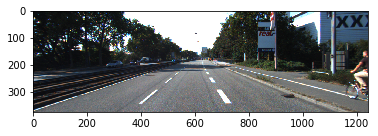

In [348]:
img = mpimg.imread(base_path + '/data_object_image_3/training/image_3/' +current_file+".png")
plt.imshow(img)

In [349]:
# !ls ../training_files/tmp

In [350]:
with model.graph.as_default():
    
#   assigns2 = []
#   for k, v in assigns.items():
#         try:
#             assigns2.append(tf.assign(new_variables_dict[k], v))
#         except:
#             pass
            
  config = tf.ConfigProto()
  config.gpu_options.allow_growth = True

  with tf.Session(config=config) as sess:
    model.saver.restore(sess, tf.train.latest_checkpoint('../training_files/tmp/'))
#     model.saver.restore(sess, '../training_files/tmp/model.ckpt-35880')

 
    dataset = data_generator(base_path, i_c, list_camera_paths, list_lidar_paths, list_label_paths, list_calib_paths)
   
    i = 0
    if True:

      feed_dict = prepare_dataset_feed_dict_2(model, dataset, False, False, None, False)
   

      final_output, cls_loss, loc_loss, dim_loss, theta_loss, dir_loss,\
                        reg_loss, iou, iou_dim, iou_loc, precision, recall, theta_accuracy = sess.run([model.final_output,\
                                                              model.classification_loss, model.loc_reg_loss, model.dim_reg_loss, model.theta_reg_loss,\
                                                              model.dir_reg_loss, model.regression_loss,\
                                                             model.iou, model.iou_dim, model.iou_loc,\
                                                             model.precision, model.recall,\
                                                              model.theta_accuracy ],\
                                                             feed_dict=feed_dict) 

INFO:tensorflow:Restoring parameters from ../training_files/tmp/model.ckpt-750


In [351]:
cls_loss, loc_loss, dim_loss, theta_loss, theta_accuracy, dir_loss, reg_loss, iou, iou_dim, iou_loc, precision, recall

(665.7594,
 0.77191436,
 0.52485347,
 0.009021943,
 12.054572,
 0.55070937,
 1139.6252,
 0.26091933,
 0.3344177,
 0.36991447,
 0.0,
 0.0)

In [352]:
# recall_pos, recall_neg

In [127]:
cls_loss, loc_loss, dim_loss, theta_loss, dir_loss, reg_loss, iou, iou_dim, iou_loc, precision, recall

(2.9225216,
 0.4496003,
 0.011151988,
 0.004083068,
 0.41477248,
 396.18845,
 0.5444428,
 0.8447701,
 0.58495235,
 0.0,
 0.0)

In [128]:
cls_loss, loc_loss, dim_loss, theta_loss, dir_loss, reg_loss, iou, iou_dim, iou_loc, precision, recall

(2.9225216,
 0.4496003,
 0.011151988,
 0.004083068,
 0.41477248,
 396.18845,
 0.5444428,
 0.8447701,
 0.58495235,
 0.0,
 0.0)

In [129]:
cls_loss, loc_loss, dim_loss, theta_loss, dir_loss, reg_loss, iou, iou_dim, iou_loc, precision, recall

(2.9225216,
 0.4496003,
 0.011151988,
 0.004083068,
 0.41477248,
 396.18845,
 0.5444428,
 0.8447701,
 0.58495235,
 0.0,
 0.0)

In [130]:
iou, iou_dim, iou_loc

(0.5444428, 0.8447701, 0.58495235)

In [131]:
precision, recall

(0.0, 0.0)

In [132]:
cls_loss, loc_loss, dim_loss, theta_loss, dir_loss, reg_loss

(2.9225216, 0.4496003, 0.011151988, 0.004083068, 0.41477248, 396.18845)

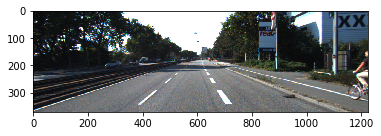

In [353]:
plt.imshow(feed_dict[model.train_inputs_rgb][0])

In [354]:
# dataset = DetectionDatasetLoader(base_path, None, 0.8, 0, True, True)

In [355]:
# camera_tensors, lidar_tensors, label_tensors, Tr_velo_to_cams, R0_rects, P3s, shift_hs, shift_ws = dataset.get_next()

In [356]:
# plt.imshow(camera_tensors[0])

In [357]:
# img = np.clip(np.mean(lidar_tensors.astype(int)[0][:, :, 13:], 2), 0, 1)
# plt.imshow(img)

In [358]:
import numpy as np
import math
from scipy.ndimage import rotate
import cv2
from data.data_utils.fv_utils import *

def in_range_points(points, x, y, z, x_range, y_range, z_range):
    """ 
    This function is imported from https://github.com/windowsub0406/KITTI_Tutorial/blob/master/Convert_Velo_2_Topview_detail.ipynb
    extract in-range points 
    """
    return points[np.logical_and.reduce((x >= x_range[0], x <= x_range[1], y >= y_range[0], \
                                         y <= y_range[1], z >= z_range[0], z <= z_range[1]))]

def rotateImage(image, angle):
  image_center = tuple(np.array(image.shape[1::-1]) / 2)
  rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
  result = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)
  return result

def velo_points_bev2(lidar_path, calib_path, x_range=(0, 71), y_range=(-40, 40), z_range=(-3.0, 1), 
                    size=(512, 448, 40), img_width=1224, img_height=370, translate_x=0, translate_y=0, translate_z = 0, ang=0, fliplr=False):
    """
    # TODO :  8-neighbor interpolation
    """
    points = np.fromfile(lidar_path, dtype=np.float32).reshape(-1, 4)
    calib = Calibration(calib_path)
    imgfov_pc_velo, pts_2d, fov_inds = get_lidar_in_image_fov(points[:, :3],
        calib, 0, 0, img_width, img_height, True)
    # points = imgfov_pc_velo
    points = points[fov_inds, :]
    x = points[:, 0]
    y = points[:, 1]
    z = points[:, 2]
    intensity = points[:, 3]

    x_lim = in_range_points(x, x, y, z, x_range, y_range, z_range)
    y_lim = in_range_points(y, x, y, z, x_range, y_range, z_range)
    z_lim = in_range_points(z, x, y, z, x_range, y_range, z_range)
    i_lim = in_range_points(intensity, x, y, z, x_range, y_range, z_range)

    x_lim -= translate_x
    y_lim -= translate_y
    z_lim -= translate_z
    x_range = (x_range[0] + translate_x, x_range[1] + translate_x)
    y_range = (y_range[0] + translate_y, y_range[1] + translate_y)
    z_range = (z_range[0] + translate_z, z_range[1] + translate_z)

    x_size = (x_range[1] - x_range[0])
    y_size = (y_range[1] - y_range[0])
    z_size = (z_range[1] - z_range[0])
        
    x_fac = (size[0]-1) / x_size
    y_fac = (size[1]-1) / y_size
    z_fac = (size[2]-1) / z_size

    # if x_range[0] < 0:
    x_lim = x_lim + -1*x_range[0]
    # if y_range[0] < 0:
    y_lim = y_lim + -1*y_range[0]
    # if z_range[0] < 0:
    z_lim = z_lim + -1*z_range[0]
        
    x_lim = -1 * (x_lim * x_fac).astype(np.int32)
    y_lim = -1 * (y_lim * y_fac).astype(np.int32)
    z_lim = 1 * (z_lim * z_fac).astype(np.int32)

    x_lim2 = x_lim[:]
    y_lim2 = y_lim[:]
    z_lim2 = z_lim[:]
    i_lim2 = i_lim[:]

    x_lim = x_lim[(x_lim2>-size[0]) & (x_lim2<= 0) & (y_lim2>-size[1]) & (y_lim2 <= 0) & (z_lim2<size[2]) & (z_lim2 >= 0)]
    y_lim = y_lim[(x_lim2>-size[0]) & (x_lim2<= 0) & (y_lim2>-size[1]) & (y_lim2 <= 0) & (z_lim2<size[2]) & (z_lim2 >= 0)]
    z_lim = z_lim[(x_lim2>-size[0]) & (x_lim2<= 0) & (y_lim2>-size[1]) & (y_lim2 <= 0) & (z_lim2<size[2]) & (z_lim2 >= 0)]
    i_lim = i_lim[(x_lim2>-size[0]) & (x_lim2<= 0) & (y_lim2>-size[1]) & (y_lim2 <= 0) & (z_lim2<size[2]) & (z_lim2 >= 0)]
    
    
    img = np.zeros([size[0], size[1], size[2]+1], dtype=np.float32)
    # occupancy grid
    img[x_lim, y_lim, z_lim] = 255.
    img[x_lim, y_lim, -1] = i_lim * 255.
    if fliplr:
        img = np.fliplr(img)
    if ang != 0:
        # img = rotate(img, ang, reshape=False)
        img = rotateImage(img, ang)
        img[img<255//2]=0
        img[img>=255//2]=255.
    return img

In [359]:

# current_file = list_files2[3]
    
translate_x = 0
translate_y = 0
translate_z = 0
ang = 0
fliplr = False

# i_c = 25
# current_file = list_files2[i_c]
# current_file

h, w, _ = cv2.imread(base_path + '/data_object_image_3/training/image_3/'+ current_file + '.png').shape
all_data, label, Tr_velo_to_cam, R0_rect, P3, directions = read_label(base_path + '/data_object_label_2/training/label_2/'+ current_file + '.txt', 
                                                  base_path + '/data_object_calib/training/calib/'+ current_file + '.txt', 
                                                  0, 0, get_actual_dims=True,
                                                         ang=ang, translate_x=translate_x,
                                              translate_y=translate_y, translate_z=translate_z, fliplr=fliplr)

lidar_image = velo_points_bev(base_path + '/data_object_velodyne/training/velodyne/'+ current_file + '.bin',
                              base_path + '/data_object_calib/training/calib/'+ current_file + '.txt',
                           size=(512, 448, 40), img_height=375, img_width=1242, ang=ang, translate_x=translate_x,
                              translate_y=translate_y, translate_z=translate_z, fliplr=fliplr)

# label = get_target(label, directions,  anchors=np.array([3.9, 1.6, 1.5]))

In [360]:
lidar_image.shape

(512, 448, 41)

In [361]:
# np.max(lidar_image[:, :, :40], axis=-1)

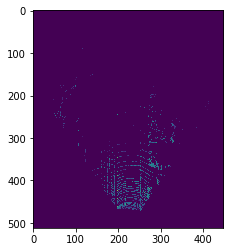

In [362]:
plt.imshow(np.max(lidar_image[:, :, 40:], axis=-1))

In [363]:
np.min(lidar_image[:, :, :])

0.0

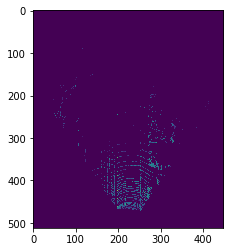

In [364]:
plt.imshow(lidar_image[:, :, -1])

In [365]:
label

array([[234.55075841, 136.58218185,  26.99572747,  28.85912279,
          9.83345524,  14.52589693,   1.57      ],
       [141.63523256, 135.56338457,  26.3440816 ,  24.54067893,
         10.05719485,  13.45351528,   1.58      ]])

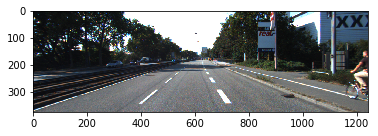

In [366]:
plt.imshow(img)

In [367]:
t = base_path + '/data_object_label_2/training/label_2/'+ current_file + '.txt'
!cat $t

Car 0.00 0 1.96 280.38 185.10 344.90 215.59 1.49 1.76 4.01 -15.71 2.16 38.26 1.57
Car 0.00 0 1.88 365.14 184.54 406.11 205.20 1.38 1.80 3.41 -15.89 2.23 51.17 1.58
DontCare -1 -1 -10 402.27 166.69 477.31 197.98 -1 -1 -1 -1000 -1000 -1000 -10
DontCare -1 -1 -10 518.53 177.31 531.51 187.17 -1 -1 -1 -1000 -1000 -1000 -10
DontCare -1 -1 -10 1207.50 233.35 1240.00 333.39 -1 -1 -1 -1000 -1000 -1000 -10
DontCare -1 -1 -10 535.06 177.65 545.26 185.82 -1 -1 -1 -1000 -1000 -1000 -10
DontCare -1 -1 -10 558.03 177.88 567.50 184.65 -1 -1 -1 -1000 -1000 -1000 -10


In [368]:
# t2 = './' + current_file + '.txt'
# !cat $t2

In [369]:
len(label)

2

In [370]:
directions

array([1., 1.])

(512, 448)
234.55075841033585 136.58218184774205 28.859122794000484 9.83345523931683 -89.954406
141.63523255864413 135.56338456755498 24.54067893355112 10.057194851542349 -90.527364



<Figure size 432x288 with 0 Axes>

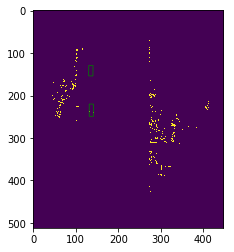

In [371]:

#groundtruth
# Create figure and axes
plt.clf()
fig,ax = plt.subplots(1)

# Display the image
img = np.clip(np.mean(lidar_image[:, :, 22:40], 2), 0, 1)
# img = np.fliplr(img)
ax.imshow(img)

print(img.shape)
for i in range(0, len(label)):
    w = label[i][3] 
    h = label[i][4] 
    x = label[i][0]
    y = label[i][1]
#     x = img.shape[0] - label[i][0]
#     y = img.shape[1] - label[i][1]
    c = 'g'
    if directions[i] >= 1.:
        c = 'b'
#     plt.scatter(y, x, s=10, c=c)
    polygon = convert5Pointto8Point(y, x, w, h, -label[i][6]*57.2958)
    xs = polygon[0::2]
    ys = polygon[1::2]
    l = []
    for j in range(4):
        l.append([xs[j], ys[j]])
    rect = patches.Polygon(l,linewidth=0.75,edgecolor='g',facecolor='none')
    ax.add_patch(rect)
    print(x, y, w, h, -label[i][6]*57.2958)

print()


plt.show()


In [372]:
lidar_image.shape

(512, 448, 41)

In [373]:
noise = np.random.rand(512, 448, 40)
noise2 = np.random.rand(512, 448, 40)

In [374]:
noise = np.array(noise>=0.1, dtype=np.int)
noise2 = np.array(noise2>=0.1, dtype=np.int)

In [375]:
np.count_nonzero(noise2*noise)

7433455

In [376]:
np.sum(noise) / (512 * 448 * 40)

0.9000306265694754

In [377]:
lidar_noise = np.array(np.clip(lidar_image * noise*noise2*1, 0, 255), dtype=np.int)

ValueError: operands could not be broadcast together with shapes (512,448,41) (512,448,40) 

(512, 448)
234.55075841033585 136.58218184774205 28.859122794000484 9.83345523931683 -89.954406
141.63523255864413 135.56338456755498 24.54067893355112 10.057194851542349 -90.527364



<Figure size 432x288 with 0 Axes>

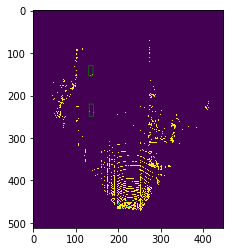

In [378]:
#groundtruth
# Create figure and axes
plt.clf()
fig,ax = plt.subplots(1)

# Display the image
img = np.clip(np.mean(lidar_image[:, :, 22:], 2), 0, 1)
# img = np.fliplr(img)
ax.imshow(img)

print(img.shape)
for i in range(0, len(label)):
    w = label[i][3] 
    h = label[i][4] 
    x = label[i][0]
    y = label[i][1]
#     x = img.shape[0] - label[i][0]
#     y = img.shape[1] - label[i][1]
    c = 'g'
    if directions[i] >= 1.:
        c = 'b'
#     plt.scatter(y, x, s=10, c=c)
    polygon = convert5Pointto8Point(y, x, w, h, -label[i][6]*57.2958)
    xs = polygon[0::2]
    ys = polygon[1::2]
    l = []
    for j in range(4):
        l.append([xs[j], ys[j]])
    rect = patches.Polygon(l,linewidth=0.75,edgecolor='g',facecolor='none')
    ax.add_patch(rect)
    print(x, y, w, h, -label[i][6]*57.2958)

print()


plt.show()

<Figure size 432x288 with 0 Axes>

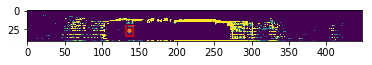

In [379]:
# Create figure and axes
plt.clf()
fig,ax = plt.subplots(1)

# Display the image
img = np.clip(np.mean(lidar_image.transpose()[:, :, :], 2), 0, 1)
# img = cv2.resize(img, (112, 128))
ax.imshow(img)

for i in range(0, len(label)):
    h = label[i][5]
    l = label[i][3] 
    w = label[i][4]
    x = label[i][0]
    y = label[i][1]
    z = label[i][2]

    plt.scatter(y, z, s=10)
    a = label[i][6]
    if a < 0:
      a = a + 3.14
#     print(h, w, l)
#     print(y, z, x)
#     print()
    rect = patches.Rectangle((y-w/2, z-h/2),w, h, angle= 0,linewidth=0.75,edgecolor='r',facecolor='none')

    ax.add_patch(rect)
    

plt.show()


In [380]:
def plot_point(point, angle, length):
     '''
     point - Tuple (x, y)
     angle - Angle you want your end point at in degrees.
     length - Length of the line you want to plot.

     Will plot the line on a 10 x 10 plot.
     '''

     # unpack the first point
     x, y = point

     # find the end point
     endy = length * math.sin(math.radians(angle))
     endx = length * math.cos(math.radians(angle))

     # plot the points
     fig = plt.figure()
     ax = plt.subplot(111)
     ax.set_ylim([0, 10])   # set the bounds to be 10, 10
     ax.set_xlim([0, 10])
     ax.plot([x, endx], [y, endy])

     fig.show()

<Figure size 432x288 with 0 Axes>

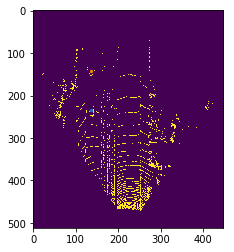

In [381]:



plt.clf()
fig,ax = plt.subplots(1)

img = np.clip(np.mean(lidar_image[:, :, :], 2), 0, 1)
ax.imshow(img)

boxes = []

for j in range(0, len(label)):

    w = label[j][5]
    h = label[j][4] 
    x = label[j][0]
    y = label[j][1]
    a = label[j][6]
    if a < 0:
          a = a + 3.14
    
    plt.scatter(y, x, s=5)

    polygon = convert5Pointto8Point(y, x, w, h, -a*57.2958)
    xs = polygon[0::2]
    ys = polygon[1::2]
    l = []
    for i in range(4):
        l.append([xs[i], ys[i]])
        
    boxes.append([xs[0], ys[0], xs[2], ys[2]])
    
    rect = patches.Polygon(l,linewidth=0.75,edgecolor='r',facecolor='none')
#     ax.add_patch(rect)
    

    
        
plt.show()

<Figure size 432x288 with 0 Axes>

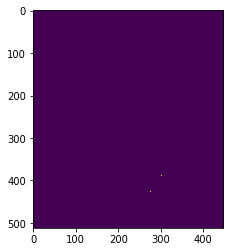

In [382]:
plt.clf()
fig,ax = plt.subplots(1)

img = np.clip(np.mean(feed_dict[model.train_inputs_lidar][0][:, :, 13:]*255, 2), 0, 1)
ax.imshow(img)     
plt.show()

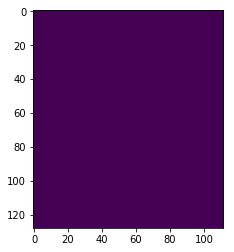

In [383]:
plt.imshow(feed_dict[model.y_true][0, :, :, 0, -1])
plt.show()

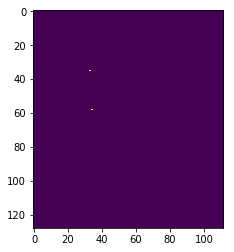

In [384]:
plt.imshow(feed_dict[model.y_true][0, :, :, 1, -1])
plt.show()

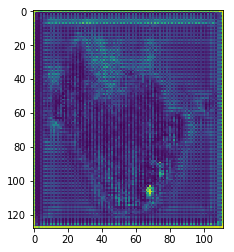

In [385]:
plt.imshow(sigmoid(final_output[0, :, :, 0, -1]))
plt.show()

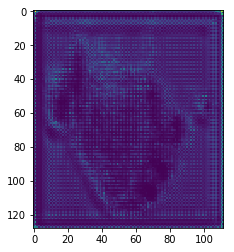

In [386]:
plt.imshow(sigmoid(final_output[0, :, :, 1, -1]))
plt.show()

In [387]:
c = (sigmoid(final_output[0, :, :, 1, -1]) * (1-feed_dict[model.y_true][0, :, :, 1, -1]))>0
np.sum(sigmoid(final_output[0, :, :, 1, -1])[c])

1132.8698

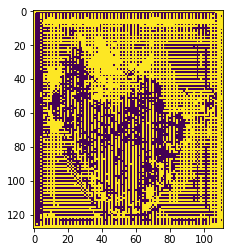

In [388]:
plt.imshow(sigmoid(final_output[0, :, :, 0, -1]) >= 0.15)
plt.show()

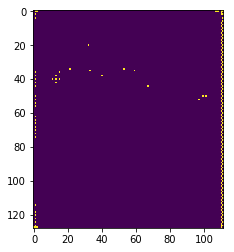

In [389]:
plt.imshow(sigmoid(final_output[0, :, :, 1, -1])>=0.3)
plt.show()

In [390]:
np.where(sigmoid(final_output[0, :, :, 1, -1])>=0.3)

(array([  0,   0,   0,   0,   0,   0,   1,   2,   2,   2,   4,   4,   6,
          7,   8,   9,  10,  11,  12,  13,  14,  15,  16,  17,  18,  19,
         20,  20,  21,  22,  23,  24,  25,  26,  27,  28,  29,  30,  31,
         32,  33,  34,  34,  34,  35,  35,  35,  36,  36,  36,  37,  38,
         38,  38,  38,  39,  40,  40,  40,  40,  40,  41,  42,  42,  42,
         43,  44,  44,  44,  45,  46,  47,  48,  49,  50,  50,  50,  50,
         51,  52,  52,  52,  53,  54,  54,  55,  56,  56,  57,  58,  59,
         60,  61,  62,  62,  63,  64,  64,  65,  66,  66,  67,  68,  68,
         69,  70,  70,  71,  72,  72,  73,  74,  74,  75,  76,  77,  78,
         79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
         92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
        105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 114, 115, 116,
        117, 118, 118, 119, 120, 120, 121, 122, 122, 123, 124, 124, 125,
        126, 126, 126, 127, 127, 127, 127]),
 array

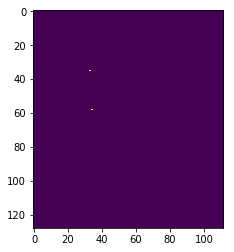

In [391]:
plt.imshow(sigmoid(feed_dict[model.y_true][0, :, :, 1, -1]))
plt.show()

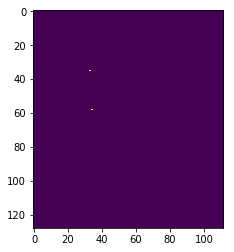

In [392]:
plt.imshow(sigmoid(feed_dict[model.y_true][0, :, :, 1, 7]))
plt.show()

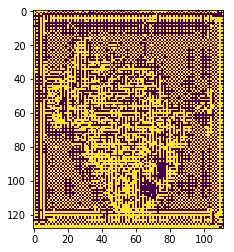

In [393]:
plt.imshow(sigmoid(final_output[0, :, :, 1, 7])>=0.5 )
plt.show()

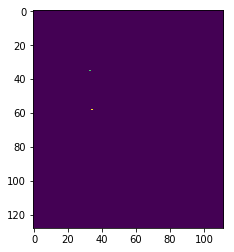

In [394]:
plt.imshow((feed_dict[model.y_true][0, :, :, 1, 8] * sigmoid(final_output[0, :, :, 1, 7])) )
plt.show()

In [395]:
np.max(sigmoid(final_output[0, :, :, 1, -1])), np.min(sigmoid(final_output[0, :, :, 1, -1]))

(0.82336485, 9.734692e-05)

In [396]:
np.max(sigmoid(final_output[0, :, :, 0, -1])), np.min(sigmoid(final_output[0, :, :, 0, -1]))

(0.9890667, 0.0075510317)

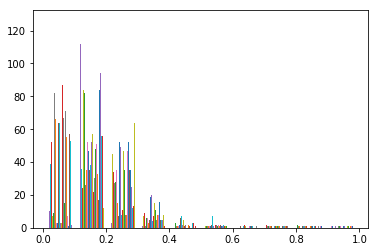

In [397]:
plt.hist(sigmoid(final_output[0, :, :, 0, -1]))
plt.show()

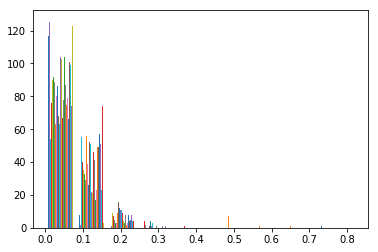

In [398]:
plt.hist(sigmoid(final_output[0, :, :, 1, -1]))
plt.show()

In [399]:
np.max(sigmoid(final_output[0, :, :, 0, -1])), np.min(sigmoid(final_output[0, :, :, 0, -1]))

(0.9890667, 0.0075510317)

In [400]:
np.min(final_output[0, :, :, :, -1]), np.max(final_output[0, :, :, :, -1])

(-9.237132, 4.5049496)

In [401]:
np.min(final_output[0, :, :, 0, -1]), np.max(final_output[0, :, :, 0, -1])

(-4.8784914, 4.5049496)

In [402]:
np.min(final_output[0, :, :, 1, -1]), np.max(final_output[0, :, :, 1, -1])

(-9.237132, 1.5393131)

In [403]:
np.max(sigmoid(final_output[0, :, :, :, -1])), np.min(sigmoid(final_output[0, :, :, :, -1]))

(0.9890667, 9.734692e-05)

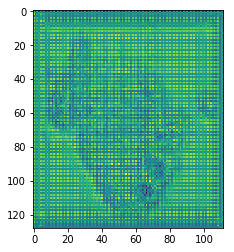

In [404]:
plt.imshow(final_output[0, :, :, 0, 5])
plt.show()

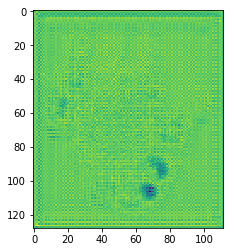

In [405]:
plt.imshow(final_output[0, :, :, 1, 5])
plt.show()

In [406]:
len(label)

2

In [407]:
t0 = np.where(sigmoid(feed_dict[model.y_true][0, :, :, 1, -1])>=0.7)
t0

(array([35, 58]), array([33, 34]))

In [408]:
len(t0[0])

2

In [409]:
t1 = np.where(sigmoid(final_output[0, :, :, 1, -1])>=0.5)
t1

(array([  0,   0,   0,   1,   2,   2,   4, 120]),
 array([  1, 110, 111, 110, 110, 111,   1,   1]))

In [410]:
len(t1[0])

8

In [411]:
i = 0
a = t0[0][i]
b = t0[1][i]

In [412]:
print(np.tanh(final_output[0, a, b, 1, :3])*0.5)
print(final_output[0, a, b, 1, 3:6])
print(sigmoid(final_output[0, a, b, 1, 7:]))
print(sigmoid(final_output[0, a, b, 1, 6]) * np.pi/2 - np.pi/4)
print((sigmoid(final_output[0, a, b, 1, 6]) * np.pi/2 - np.pi/4)*57.2958)
print(sigmoid(final_output[0, a, b, 1, 6]))

[-0.2600927   0.15163018  0.34399933]
[ 0.7484713 -2.0831227 -1.4630376]
[0.48492798 0.32517695]
-0.18516423306211027
-10.609132864680058
0.3821208


In [413]:
(sigmoid(final_output[0, a, b, 1, 6]) - (feed_dict[model.y_true][0, a, b, 1, 6] + np.pi/4) / (np.pi/2)) ** 2 * 0.5

0.007655602292452057

In [414]:
(sigmoid(final_output[0, a, b, 1, 6]) * np.pi/2 - np.pi/4)*57.2958 - (feed_dict[model.y_true][0, a, b, 1, 6]) * 57.2958


-11.136464691655814

In [415]:
(0.0005802480361840552 + 0.00346892330888346 + 0.027389291512064477) / 3

0.010479487619043997

In [416]:
theta_loss

0.009021943

In [417]:
(0.02079633* (3.14/2)) - (3.14/4)

-0.7523497619

In [418]:
print(feed_dict[model.y_true][0, a, b, 1, :3])
print(feed_dict[model.y_true][0, a, b, 1, 3:6])
print(feed_dict[model.y_true][0, a, b, 1, 6:])
print(feed_dict[model.y_true][0, a, b, 1, 6])
print((feed_dict[model.y_true][0, a, b, 1, 6]) * 57.2958)
print((feed_dict[model.y_true][0, a, b, 1, 6] + np.pi/4) / (np.pi/2))

[-0.02338253  0.24427883  0.10573469]
[-0.13426426  0.11778303 -0.08338161]
[0.00920367 1.         1.        ]
0.009203673
0.5273318269757554
0.5058592404268984


In [419]:
90 + (feed_dict[model.y_true][0, a, b, 1, 6]) * 57.2958

90.52733182697575

In [420]:
v = np.tanh(final_output[0, a, b, 1, :3])*0.5 - feed_dict[model.y_true][0, a, b, 1, :3]
print(v)
# print(v*np.array([3.9, 1.6, 1.5]) * np.array([4, 4, 40]))

[-0.23671018 -0.09264866  0.23826464]


In [421]:
# v = np.array([3.9, 1.6, 1.5]) * np.array([4, 4, 40])
# print(v)
# print(v/min(v))

In [422]:
v = np.maximum(0, final_output[0, a, b, 1, 3:6]) - feed_dict[model.y_true][0, a, b, 1, 3:6]
print(v)
print(np.square(v) * np.array([3.9, 1.6, 1.5]))
print(v / min(v))
print(np.array([3.9, 1.6, 1.5]) / 1.5)

[ 0.8827356  -0.11778303  0.08338161]
[3.03896631 0.02219655 0.01042874]
[-7.4945908   1.         -0.70792544]
[2.6        1.06666667 1.        ]


In [423]:
def read_label2(label_path, calib_path, shift_h, shift_w, x_range=(0, 71), y_range=(-40, 40), z_range=(-3.0, 1), 
                    size=(512, 448, 40), get_actual_dims=False, from_file=True, translate_x=0, translate_y=0, ang=0, get_neg=False):
#     return __read_label(label_path, calib_path, shift_h, shift_w, x_range=x_range, y_range=y_range, z_range=z_range, 
#                     size=size, get_actual_dims=get_actual_dims, from_file=from_file, translate_x=translate_x, translate_y=translate_y, ang=ang, get_neg=get_neg)



# def __read_label(label_path, calib_path, shift_h, shift_w, x_range=(0, 71), y_range=(-40, 40), z_range=(-3.0, 1), 
#                     size=(512, 448, 32), get_actual_dims=False, from_file=True, translate_x=0, translate_y=0, ang=0,
#                     get_neg=False):
    """
    the file format is as follows: 
    type, truncated, occluded, alpha, bbox_left, bbox_top, bbox_right, bbox_bottom,
    dimensions_height, dimensions_width, dimensions_length, location_x, location_y, location_z,
    rotation_y, score) 
    """
    if from_file:
        lines = []
        with open(label_path) as label_file:
            lines = label_file.readlines()
    else:
        lines = label_path.split('\n')
    # filter car class
    lines = list(map(lambda x: x.split(), lines))
    print('lines', len(lines))
    if len(lines) > 0:
        if get_neg:
            lines = list(filter(lambda x: len(x) > 0 and ( x[0] not in ['Car', 'Van', 'Truck', 'Tram', 'DontCare']), lines))
            if len(lines) > 0:
                lines = lines[:1]
        else:
            lines = list(filter(lambda x: len(x) > 0 and ( x[0] in ['Car']), lines))
#             print(len(lines))
    
    def get_parameter(index):
        return list(map(lambda x: x[index], lines))
    
    classes = get_parameter(0)
    dimension_height = np.array(get_parameter(8)).astype(float)
    dimension_width = np.array(get_parameter(9)).astype(float)
    dimension_length = np.array(get_parameter(10)).astype(float)
    # TODO: take shift into consideration - URGENT
    location_x = np.array(get_parameter(11)).astype(float)
    location_y = np.array(get_parameter(12)).astype(float)
    location_z = np.array(get_parameter(13)).astype(float)
    angles = np.array(get_parameter(14)).astype(float)
    
    # print(len(classes))
    calib_data = read_calib(calib_path)

    locations = np.array([[location_x[i], location_y[i], location_z[i]] for i in range(len(classes))])
    print('locations', len(locations))
    if len(locations) > 0 and len(locations[0]) > 0:
        locations = project_rect_to_velo(locations, calib_data['R0_rect'].reshape((3, 3)), calib_data['Tr_velo_to_cam'].reshape((3, 4)))
    print('locations', len(locations))
    # print(z_range)
    indxes = np.array(list(map(lambda point: (point[0] >= x_range[0]  and point[0] <= x_range[1])
                                    and (point[1] >= y_range[0] and point[1] <= y_range[1])
                                    and (point[2] >= z_range[0] and point[2] <= z_range[1]) , locations)))
#     print("indxes", len(indxes[indxes==True]))
#     print("indxes", indxes)
    print(locations)
    locations = np.array(list(filter(lambda point: (point[0] >= x_range[0]  and point[0] <= x_range[1])
                                    and (point[1] >= y_range[0] and point[1] <= y_range[1])
                                    and (point[2] >= z_range[0] and point[2] <= z_range[1]) , locations)))

    print(locations)
    print('locations', len(locations))
    if len(locations) > 0:
        locations[:, :2] = locations[:, :2] - np.array([translate_x, translate_y])

    # print('.......')
    

    points = [project_point_from_camera_coor_to_velo_coor([location_x[i], location_y[i], location_z[i]], 
                                                        [dimension_height[i], dimension_width[i], dimension_length[i]],
                                                        angles[i],
                                                         calib_data)
                for i in range(len(locations))]
    
    x_size = (x_range[1] - x_range[0])
    y_size = (y_range[1] - y_range[0])
    z_size = (z_range[1] - z_range[0])
            
    x_fac = (size[0]-1) / x_size
    y_fac = (size[1]-1) / y_size
    z_fac = (size[2]-1) / z_size
    if get_actual_dims:
        import math
        for i in range(len(points)):
            b = points[i]
            x0 = b[0][0]
            y0 = b[0][1]
            x1 = b[1][0]
            y1 = b[1][1]
            x2 = b[2][0]
            y2 = b[2][1]
            u0 = -(x0) * x_fac + size[0]
            v0 = -(y0 + 40) * y_fac + size[1]
            u1 = -(x1) * x_fac + size[0]
            v1 = -(y1 + 40) * y_fac + size[1]
            u2 = -(x2) * x_fac + size[0]
            v2 = -(y2 + 40) * y_fac + size[1]
            # print(dimension_length[i])
            dimension_length[i] = math.sqrt((v1-v2)**2 + (u1-u2)**2)
            # print(dimension_length[i])
            dimension_width[i] = math.sqrt((v1-v0)**2 + (u1-u0)**2)
            # print(dimension_height[i])
            dimension_height[i] = math.sqrt((-(b[0][2]+(-1*z_range[1]))*z_fac-(-b[4][2]+z_range[1])*z_fac)**2)
            # print(dimension_height[i])

      


    x_range = (x_range[0] + translate_x, x_range[1] + translate_x)
    y_range = (y_range[0] + translate_y, y_range[1] + translate_y)
    output = [[-(locations[i][0]) * x_fac + size[0], -(locations[i][1] + -1*y_range[0]) * y_fac + size[1], -(locations[i][2] + -1*z_range[0]) * z_fac + size[2], 
                dimension_length[i], dimension_width[i], dimension_height[i], angles[i]] 
                for i in range(len(locations))]
    # import math
    if ang != 0:
        for i in range(len(locations)):
            w = size[0]
            h = size[1]
            output[i][0], output[i][1] = rotate2((w//2, h//2), (output[i][0], output[i][1]), ang / 57.2958)
            output[i][6] = output[i][6] - ang / 57.2958

    output = np.array(output)
    if from_file:
        return points, output, calib_data['Tr_velo_to_cam'], calib_data['R0_rect'], calib_data['P2']
    else:
        return output, indxes




In [424]:

from datetime import datetime



<Figure size 432x288 with 0 Axes>

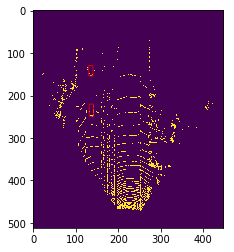

In [425]:
#groundtruth
# Create figure and axes
plt.clf()
fig,ax = plt.subplots(1)

# Display the image
img = np.clip(np.mean(lidar_image[:, :, :], 2), 0, 1)
# img = cv2.resize(img, (112, 128))
ax.imshow(img)

for i in range(0, len(label)):
    w = label[i][3]
    h = label[i][4] 
    x = label[i][0]
    y = label[i][1]
#     plt.scatter(y, x, s=15)
    a = label[i][6]
    if a < 0:
      a = a + 3.14
#     print(w, h, a*57.2958
#     rect = patches.Rectangle((y, x),w, h, angle= a*57.2958,linewidth=0.75,edgecolor='r',facecolor='none')

#     ax.add_patch(rect)
    
    polygon = convert5Pointto8Point(y, x, w, h, -a*57.2958)
    xs = polygon[0::2]
    ys = polygon[1::2]
    l = []
    for i in range(4):
        l.append([xs[i], ys[i]])

    rect = patches.Polygon(l,linewidth=0.75,edgecolor='r',facecolor='none')
    ax.add_patch(rect)



plt.show()


2
[[ 1.3794255e+02  1.3497043e+02  4.0639957e+01  8.2436886e+00
   1.6000000e+00  1.5000000e+00  1.3856322e+00 -6.0306355e-02
  -7.3008096e-01]
 [ 2.3601222e+02  1.3703146e+02  4.5851326e+01  3.9000001e+00
   1.6000000e+00  4.6810880e+00  1.3435841e+00  7.7898312e-01
  -2.2004328e+00]]
-------------------
lines 2
locations 2
locations 2
[[51.97276184 16.02318856 -3.06563693]
 [38.34664185 15.65432323 -3.60013628]]
[]
locations 0
0 2
not the same
136.58218184774205 234.55075841033585 28.859122794000484 9.83345523931683 -89.954406
135.56338456755498 141.63523255864413 24.54067893355112 10.057194851542349 -90.527364




<Figure size 432x288 with 0 Axes>

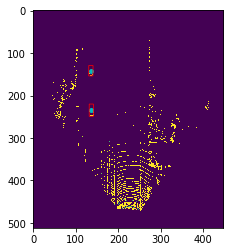

In [426]:
th=0.00001
truth_value = feed_dict[model.y_true][0, :, :, :, :]
# truth_value = None
converted_points = convert_prediction_into_real_values(final_output[0, :, :, :, :], truth_value=truth_value, th=th)
print(len(converted_points))
# converted_points = convert_prediction_into_real_values(final_output[0, :, :, :, :], th=th)
points = get_points(converted_points, base_path + '/data_object_calib/training/calib/'+ current_file + '.txt', th=th)
print(converted_points)
res = '\n'.join([' '.join([str(l) for l in points[i]]) for i in range(len(points))])

# print(np.array([points[i][-1] for i in range(len(points))]))
now = datetime.now()
current_time = now.strftime("%H:%M:%S")
# print("Current Time =", current_time)
if True:
        print('-------------------')
        labels, indxes = read_label2(res, base_path + '/data_object_calib/training/calib/'+ current_file + '.txt', 0, 0, get_actual_dims=True, from_file=False)
        print(len(labels), len(points))
        if len(labels) != len(points):
            print('not the same')

        points = np.array(points)
        points = points[indxes]
        if len(labels) > 0:
            selected_idx = nms(labels, np.array([points[i][-1] for i in range(len(points))]), max_output_size=100, iou_threshold=0.3)
        else:
            selected_idx = []
#         print('done', len(selected_idx))
        
        if len(selected_idx) > 0:
            points = points[selected_idx]
            res = '\n'.join([' '.join([str(l) for l in points[i]]) for i in range(len(points))])
        else:
            res=""
            
now = datetime.now()
current_time = now.strftime("%H:%M:%S")
# print("Current Time =", current_time)   
text_file = open('./' + current_file + '.txt', "wb+")
text_file.write(res.encode())
text_file.close()

all_data, label_bev, Tr_velo_to_cam, R0_rect, P3, _ = read_label('./'+ current_file + '.txt', 
                                                  base_path + '/data_object_calib/training/calib/'+ current_file + '.txt', 
                                                  0, 0, get_actual_dims=True)

#groundtruth
# Create figure and axes
plt.clf()
fig,ax = plt.subplots(1)

# Display the image
img = np.clip(np.mean(lidar_image[:, :, 18:], 2), 0, 1)
# img = cv2.resize(img, (112, 128))
ax.imshow(img)

for i in range(0, len(label)):
    w = label[i][3]
    h = label[i][4] 
    x = label[i][0]
    y = label[i][1]
   
    plt.scatter(y, x, s=15, c='c')
    a = label[i][6]
    if a < 0:
      a = a + 3.14
    
    print(y, x, w, h, -a*57.2958)
#     print(w, h, a*57.2958
#     rect = patches.Rectangle((y, x),w, h, angle= a*57.2958,linewidth=0.75,edgecolor='r',facecolor='none')

#     ax.add_patch(rect)
    
    polygon = convert5Pointto8Point(y, x, w, h, -a*57.2958)
    xs = polygon[0::2]
    ys = polygon[1::2]
    l = []
    for j in range(4):
        l.append([xs[j], ys[j]])

    rect = patches.Polygon(l,linewidth=0.75,edgecolor='r',facecolor='none')
    ax.add_patch(rect)
#     if i == 1:
#         break
 
print()

for i in range(0, len(label_bev)):
    w = label_bev[i][3] 
    h = label_bev[i][4] 
    x = label_bev[i][0]
    y = label_bev[i][1]
    print(y, x, w, h, -label_bev[i][6]*57.2958)
    ax.scatter(y, x, s=10, c='b')
    polygon = convert5Pointto8Point(y, x, w, h, -label_bev[i][6]*57.2958)
    xs = polygon[0::2]
    ys = polygon[1::2]
    l = []
    for i in range(4):
        l.append([xs[i], ys[i]])

    rect = patches.Polygon(l,linewidth=0.75,edgecolor='g',facecolor='none')
    ax.add_patch(rect)

print()


plt.show()


lines 14320
locations 14320
locations 14320
[[ 71.91838057  39.35897279  -3.75612343]
 [ 70.87071826  40.21395126  -3.28901549]
 [ 70.34972341  39.04835609  -0.14608193]
 ...
 [  1.2680947  -39.47577794  -1.67907313]
 [  0.75572447 -40.16540143  -3.24398861]
 [  0.17572286 -39.44780281  -3.44494609]]
[[ 7.03497234e+01  3.90483561e+01 -1.46081928e-01]
 [ 6.99802829e+01  3.80957563e+01 -1.31375300e+00]
 [ 7.00844246e+01  3.67003741e+01 -2.37342236e+00]
 ...
 [ 1.28351117e-02 -3.80508597e+01  3.44571650e-01]
 [ 3.78451615e-01 -3.93919618e+01  9.24900379e-01]
 [ 1.26809470e+00 -3.94757779e+01 -1.67907313e+00]]
locations 8469
8469 14320
not the same
136.58218184774205 234.55075841033585 28.859122794000484 9.83345523931683 -89.954406
135.56338456755498 141.63523255864413 24.54067893355112 10.057194851542349 -90.527364

439.9348926268924 5.187478734209492 24.3030745052458 10.634664010566922 -142.5520649916
444.602586522756 509.27621443330605 50.428089866646694 11.12153400224409 -155.747780475

<Figure size 432x288 with 0 Axes>

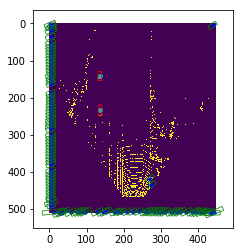

In [427]:
th=0.1
# truth_value = feed_dict[model.y_true][0, :, :, :, :]
truth_value = None
converted_points = convert_prediction_into_real_values(final_output[0, :, :, :, :], truth_value=truth_value, th=th)
# converted_points = convert_prediction_into_real_values(final_output[0, :, :, :, :], th=th)
points = get_points(converted_points, base_path + '/data_object_calib/training/calib/'+ current_file + '.txt', th=th)

res = '\n'.join([' '.join([str(l) for l in points[i]]) for i in range(len(points))])

# print(np.array([points[i][-1] for i in range(len(points))]))
now = datetime.now()
current_time = now.strftime("%H:%M:%S")
# print("Current Time =", current_time)
if True:
        labels, indxes = read_label2(res, base_path + '/data_object_calib/training/calib/'+ current_file + '.txt', 0, 0, get_actual_dims=True, from_file=False)
        print(len(labels), len(points))
        if len(labels) != len(points):
            print('not the same')

        points = np.array(points)
        points = points[indxes]
        if len(labels) > 0:
            selected_idx = nms(labels, np.array([points[i][-1] for i in range(len(points))]), max_output_size=100, iou_threshold=0.3)
        else:
            selected_idx = []
#         print('done', len(selected_idx))
        
        if len(selected_idx) > 0:
            points = points[selected_idx]
            res = '\n'.join([' '.join([str(l) for l in points[i]]) for i in range(len(points))])
        else:
            res=""
            
now = datetime.now()
current_time = now.strftime("%H:%M:%S")
# print("Current Time =", current_time)   
text_file = open('./' + current_file + '.txt', "wb+")
text_file.write(res.encode())
text_file.close()

all_data, label_bev, Tr_velo_to_cam, R0_rect, P3, _ = read_label('./'+ current_file + '.txt', 
                                                  base_path + '/data_object_calib/training/calib/'+ current_file + '.txt', 
                                                  0, 0, get_actual_dims=True)

#groundtruth
# Create figure and axes
plt.clf()
fig,ax = plt.subplots(1)

# Display the image
img = np.clip(np.mean(lidar_image[:, :, 18:], 2), 0, 1)
# img = cv2.resize(img, (112, 128))
ax.imshow(img)

for i in range(0, len(label)):
    w = label[i][3]
    h = label[i][4] 
    x = label[i][0]
    y = label[i][1]
   
    plt.scatter(y, x, s=15, c='c')
    a = label[i][6]
    if a < 0:
      a = a + 3.14
    
    print(y, x, w, h, -a*57.2958)
#     print(w, h, a*57.2958
#     rect = patches.Rectangle((y, x),w, h, angle= a*57.2958,linewidth=0.75,edgecolor='r',facecolor='none')

#     ax.add_patch(rect)
    
    polygon = convert5Pointto8Point(y, x, w, h, -a*57.2958)
    xs = polygon[0::2]
    ys = polygon[1::2]
    l = []
    for j in range(4):
        l.append([xs[j], ys[j]])

    rect = patches.Polygon(l,linewidth=0.75,edgecolor='r',facecolor='none')
    ax.add_patch(rect)
#     if i == 1:
#         break
 
print()

for i in range(0, len(label_bev)):
    w = label_bev[i][3] 
    h = label_bev[i][4] 
    x = label_bev[i][0]
    y = label_bev[i][1]
    print(y, x, w, h, -label_bev[i][6]*57.2958)
    ax.scatter(y, x, s=10, c='b')
    polygon = convert5Pointto8Point(y, x, w, h, -label_bev[i][6]*57.2958)
    xs = polygon[0::2]
    ys = polygon[1::2]
    l = []
    for i in range(4):
        l.append([xs[i], ys[i]])

    rect = patches.Polygon(l,linewidth=0.75,edgecolor='g',facecolor='none')
    ax.add_patch(rect)

print()


plt.show()


215.21584510963083 19.144778977503226
184.78747871195867 26.750890869977106

215.3937993051349 20.9904040388677


<Figure size 432x288 with 0 Axes>

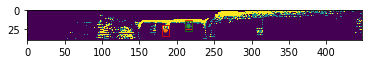

In [982]:
# Create figure and axes
plt.clf()
fig,ax = plt.subplots(1)

# Display the image
img = np.clip(np.mean(lidar_image.transpose()[:, :, :], 2), 0, 1)
# img = cv2.resize(img, (112, 128))
ax.imshow(img)

for i in range(0, len(label)):
    l = label[i][3]
    w = label[i][4] 
    h = label[i][5]
    x = label[i][0]
    y = label[i][1]
    z = label[i][2]
    print(y, z)
    plt.scatter(y, z, s=10)
    a = label[i][6]
    if a < 0:
      a = a + 3.14
#     print(h, w, l)
#     print(y, z, x)
#     print()
    rect = patches.Rectangle((y-w/2, z-h/2),w, h, angle= 0,linewidth=0.75,edgecolor='r',facecolor='none')

    ax.add_patch(rect)
    
print()
for i in range(0, len(label_bev)):
    l = label_bev[i][3]
    w = label_bev[i][4] 
    h = label_bev[i][5]
    x = label_bev[i][0]
    y = label_bev[i][1]
    z = label_bev[i][2]
    print(y, z)
    plt.scatter(y, z, s=10)
    a = label_bev[i][6]
    if a < 0:
      a = a + 3.14
#     print(h, w, l)
#     print(y, z, x)
#     print()
    rect = patches.Rectangle((y-w/2, z-h/2),w, h, angle= 0,linewidth=0.75,edgecolor='g',facecolor='none')

    ax.add_patch(rect)
    
plt.show()


In [97]:
current_file

'000004'

In [185]:
!cat ./003708.txt

cat: ./003708.txt: No such file or directory


In [186]:
!cat ../prediction_files/predictions_focal_model_new_10_best_nms2/bev/th20_2/data/003708.txt

cat: ../prediction_files/predictions_focal_model_new_10_best_nms2/bev/th20_2/data/003708.txt: No such file or directory


In [187]:
!cat ../../../Data/data_object_label_2/training/label_2/003708.txt

Car 0.74 1 2.16 0.00 211.33 232.70 374.00 1.43 1.74 3.63 -5.07 1.85 6.30 1.50
Car 0.00 0 -1.70 665.32 187.08 744.90 241.72 1.38 1.73 3.97 2.62 1.82 20.96 -1.58
Car 0.00 1 -2.99 920.92 166.22 1089.74 235.15 1.74 1.58 3.90 10.86 1.60 20.00 -2.50
Car 0.00 2 -1.67 652.36 182.97 708.36 227.68 1.50 1.62 4.11 2.49 1.89 26.73 -1.58
Car 0.00 0 1.75 467.39 184.45 514.41 218.43 1.58 1.68 3.76 -5.96 2.18 36.27 1.59
Car 0.00 2 -2.85 824.52 176.24 961.81 220.51 1.49 1.53 4.38 10.20 1.64 26.24 -2.49
Car 0.00 2 -2.96 876.23 176.57 1022.73 229.30 1.55 1.80 3.98 10.80 1.69 23.12 -2.53
Car 0.00 1 -1.57 636.82 176.77 661.24 201.13 1.77 1.77 5.10 2.99 2.10 55.59 -1.51
Car 0.65 0 -2.13 853.17 210.05 1241.00 374.00 1.35 1.64 3.76 3.34 1.72 5.52 -1.61
DontCare -1 -1 -10 266.98 187.00 359.78 209.93 -1 -1 -1 -1000 -1000 -1000 -10
DontCare -1 -1 -10 516.03 184.41 544.14 209.93 -1 -1 -1 -1000 -1000 -1000 -10
DontCare -1 -1 -10 561.31 177.30 616.59 197.00 -1 -1 -1 -1000 -1000 -1000 -10


In [100]:
28.589532366799695 - 27.443132743480575

1.1463996233191196

In [101]:
from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]

get_available_gpus()

['/device:CPU:0', '/device:XLA_CPU:0']

In [102]:
len(label_bev)

2

In [103]:
label.shape

(2, 7)

<Figure size 432x288 with 0 Axes>

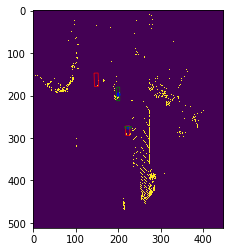

In [104]:
th=0.2
truth_value = None
converted_points = convert_prediction_into_real_values(final_output[0, :, :, :, :], truth_value=truth_value, th=th)
points = get_points(converted_points, base_path + '/data_object_calib/training/calib/'+ current_file + '.txt', th=th)

res = '\n'.join([' '.join([str(l) for l in points[i]]) for i in range(len(points))])
text_file = open('./' + current_file + '.txt', "wb+")
text_file.write(res.encode())
text_file.close()

all_data, label_bev, Tr_velo_to_cam, R0_rect, P3, _ = read_label('./'+ current_file + '.txt', 
                                                  base_path + '/data_object_calib/training/calib/'+ current_file + '.txt', 
                                                  0, 0, get_actual_dims=True)

#groundtruth
# Create figure and axes
plt.clf()
fig,ax = plt.subplots(1)

# Display the image
img = np.clip(np.mean(lidar_image[:, :, 13:], 2), 0, 1)
# img = cv2.resize(img, (112, 128))
ax.imshow(img)

for i in range(0, len(label)):
    w = label[i][3]
    h = label[i][4] 
    x = label[i][0]
    y = label[i][1]
#     plt.scatter(y, x, s=15)
    a = label[i][6]
    if a < 0:
      a = a + 3.14
#     print(w, h, a*57.2958
#     rect = patches.Rectangle((y, x),w, h, angle= a*57.2958,linewidth=0.75,edgecolor='r',facecolor='none')

#     ax.add_patch(rect)
    
    polygon = convert5Pointto8Point(y, x, w, h, -a*57.2958)
    xs = polygon[0::2]
    ys = polygon[1::2]
    l = []
    for i in range(4):
        l.append([xs[i], ys[i]])

    rect = patches.Polygon(l,linewidth=0.75,edgecolor='r',facecolor='none')
    ax.add_patch(rect)
 
print()

for i in range(0, len(label_bev)):
    w = label_bev[i][3] 
    h = label_bev[i][4] 
    x = label_bev[i][0]
    y = label_bev[i][1]
    plt.scatter(y, x, s=10, c='b')
    polygon = convert5Pointto8Point(y, x, w, h, -label_bev[i][6]*57.2958)
    xs = polygon[0::2]
    ys = polygon[1::2]
    l = []
    for i in range(4):
        l.append([xs[i], ys[i]])

    rect = patches.Polygon(l,linewidth=0.75,edgecolor='g',facecolor='none')
    ax.add_patch(rect)

print()


plt.show()


<Figure size 432x288 with 0 Axes>

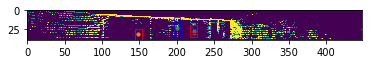

In [105]:
# Create figure and axes
plt.clf()
fig,ax = plt.subplots(1)

# Display the image
img = np.clip(np.mean(lidar_image.transpose()[:, :, :], 2), 0, 1)
# img = cv2.resize(img, (112, 128))
ax.imshow(img)

for i in range(0, len(label)):
    l = label[i][3]
    w = label[i][4] 
    h = label[i][5]
    x = label[i][0]
    y = label[i][1]
    z = label[i][2]

    plt.scatter(y, z, s=10)
    a = label[i][6]
    if a < 0:
      a = a + 3.14
#     print(h, w, l)
#     print(y, z, x)
#     print()
    rect = patches.Rectangle((y-w/2, z-h/2),w, h, angle= 0,linewidth=0.75,edgecolor='r',facecolor='none')

    ax.add_patch(rect)
    

for i in range(0, len(label_bev)):
    l = label_bev[i][3]
    w = label_bev[i][4] 
    h = label_bev[i][5]
    x = label_bev[i][0]
    y = label_bev[i][1]
    z = label_bev[i][2]

    plt.scatter(y, z, s=10)
    a = label_bev[i][6]
    if a < 0:
      a = a + 3.14
#     print(h, w, l)
#     print(y, z, x)
#     print()
    rect = patches.Rectangle((y-w/2, z-h/2),w, h, angle= 0,linewidth=0.75,edgecolor='b',facecolor='none')

    ax.add_patch(rect)
    
plt.show()


In [106]:
len(label_bev)

2

21.94980954544293 9.666128895408287 89.381448
31.371942198254086 9.557154690595818 88.235532

9.884771471667172 13.587479943400659 94.06069285356
0.0 15.06053129652173 89.49488222484



<Figure size 432x288 with 0 Axes>

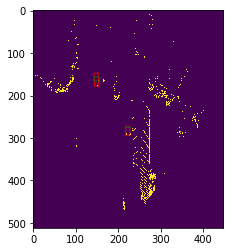

In [107]:
th=0.01
truth_value = feed_dict[model.y_true][0, :, :, :, :]
converted_points = convert_prediction_into_real_values(final_output[0, :, :, :, :], truth_value=truth_value, th=th)
points = get_points(converted_points, base_path + '/data_object_calib/training/calib/'+ current_file + '.txt', th=th)

res = '\n'.join([' '.join([str(l) for l in points[i]]) for i in range(len(points))])
text_file = open('./' + current_file + '.txt', "wb+")
text_file.write(res.encode())
text_file.close()

all_data, label_bev, Tr_velo_to_cam, R0_rect, P3, _ = read_label('./'+ current_file + '.txt', 
                                                  base_path + '/data_object_calib/training/calib/'+ current_file + '.txt', 
                                                  0, 0, get_actual_dims=True)

#groundtruth
# Create figure and axes
plt.clf()
fig,ax = plt.subplots(1)

# Display the image
img = np.clip(np.mean(lidar_image[:, :, 13:], 2), 0, 1)
# img = cv2.resize(img, (112, 128))
ax.imshow(img)

for i in range(0, len(label)):
    w = label[i][3]
    h = label[i][4] 
    x = label[i][0]
    y = label[i][1]
#     plt.scatter(y, x, s=15)
    a = label[i][6]
    if a < 0:
      a = a + 3.14
    print(w, h, a*57.2958)
#     rect = patches.Rectangle((y, x),w, h, angle= a*57.2958,linewidth=0.75,edgecolor='r',facecolor='none')

#     ax.add_patch(rect)
    
    polygon = convert5Pointto8Point(y, x, w, h, -a*57.2958)
    xs = polygon[0::2]
    ys = polygon[1::2]
    l = []
    for i in range(4):
        l.append([xs[i], ys[i]])

    rect = patches.Polygon(l,linewidth=0.75,edgecolor='r',facecolor='none')
    ax.add_patch(rect)
 
print()

for i in range(0, len(label_bev)):
    w = label_bev[i][5] 
    h = label_bev[i][4] 
    x = label_bev[i][0]
    y = label_bev[i][1]
#     plt.scatter(y, x, s=10, c='b')
    print(w, h, label_bev[i][6]*57.2958)
    polygon = convert5Pointto8Point(y, x, w, h, -label_bev[i][6]*57.2958)
    xs = polygon[0::2]
    ys = polygon[1::2]
    l = []
    for i in range(4):
        l.append([xs[i], ys[i]])

    rect = patches.Polygon(l,linewidth=0.75,edgecolor='g',facecolor='none')
    ax.add_patch(rect)

print()


plt.show()


<Figure size 432x288 with 0 Axes>

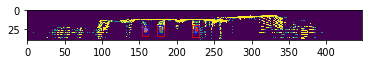

In [206]:
# Create figure and axes
plt.clf()
fig,ax = plt.subplots(1)

# Display the image
img = np.clip(np.mean(lidar_image.transpose()[:, :, :], 2), 0, 1)
# img = cv2.resize(img, (112, 128))
ax.imshow(img)

for i in range(0, len(label)):
    l = label[i][3]
    w = label[i][4] 
    h = label[i][5]
    x = label[i][0]
    y = label[i][1]
    z = label[i][2]

    plt.scatter(y, z, s=10)
    a = label[i][6]
    if a < 0:
      a = a + 3.14
#     print(h, w, l)
#     print(y, z, x)
#     print()
    rect = patches.Rectangle((y-w/2, z-h/2),w, h, angle= 0,linewidth=0.75,edgecolor='r',facecolor='none')

    ax.add_patch(rect)
    

for i in range(0, len(label_bev)):
    l = label_bev[i][3]
    w = label_bev[i][4] 
    h = label_bev[i][5]
    x = label_bev[i][0]
    y = label_bev[i][1]
    z = label_bev[i][2]

    plt.scatter(y, z, s=10)
    a = label_bev[i][6]
    if a < 0:
      a = a + 3.14
#     print(h, w, l)
#     print(y, z, x)
#     print()
    rect = patches.Rectangle((y-w/2, z-h/2),w, h, angle= 0,linewidth=0.75,edgecolor='b',facecolor='none')

    ax.add_patch(rect)
    
plt.show()


<Figure size 432x288 with 0 Axes>

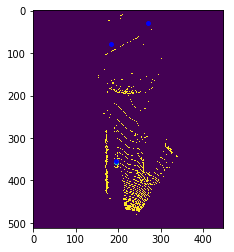

In [419]:
th=0.15
truth_value = None
converted_points = convert_prediction_into_real_values(final_output[0, :, :, :, :], truth_value=truth_value, th=th)
points = get_points(converted_points, base_path + '/data_object_calib/training/calib/'+ current_file + '.txt', th=th)

res = '\n'.join([' '.join([str(l) for l in points[i]]) for i in range(len(points))])
text_file = open('./' + current_file + '.txt', "wb+")
text_file.write(res.encode())
text_file.close()

all_data, label_bev, Tr_velo_to_cam, R0_rect, P3, _ = read_label('./'+ current_file + '.txt', 
                                                  base_path + '/data_object_calib/training/calib/'+ current_file + '.txt', 
                                                  0, 0, get_actual_dims=True)

#groundtruth
# Create figure and axes
plt.clf()
fig,ax = plt.subplots(1)

# Display the image
img = np.clip(np.mean(lidar_image[:, :, 13:], 2), 0, 1)
# img = cv2.resize(img, (112, 128))
ax.imshow(img)

for i in range(0, len(label)):
    w = label[i][5]
    h = label[i][4] 
    x = label[i][0]
    y = label[i][1]
    plt.scatter(y, x, s=15, c='c')
    a = label[i][6]
    if a < 0:
      a = a + 3.14

    polygon = convert5Pointto8Point(y, x, w, h, -a*57.2958)
    xs = polygon[0::2]
    ys = polygon[1::2]
    l = []
    for i in range(4):
        l.append([xs[i], ys[i]])

    rect = patches.Polygon(l,linewidth=0.75,edgecolor='r',facecolor='none')
#     ax.add_patch(rect)
 
print()

for i in range(0, len(label_bev)):
    w = label_bev[i][5] 
    h = label_bev[i][4] 
    x = label_bev[i][0]
    y = label_bev[i][1]
#     print(x, y)
    plt.scatter(y, x, s=15, c='b')
    polygon = convert5Pointto8Point(y, x, w, h, -label_bev[i][6]*57.2958)
    xs = polygon[0::2]
    ys = polygon[1::2]
    l = []
    for i in range(4):
        l.append([xs[i], ys[i]])

    rect = patches.Polygon(l,linewidth=0.75,edgecolor='g',facecolor='none')
#     ax.add_patch(rect)

print()


plt.show()


In [80]:
# t = './' + current_file + '.txt'
# !cat $t

<Figure size 432x288 with 0 Axes>

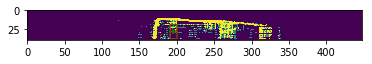

In [423]:
# Create figure and axes
plt.clf()
fig,ax = plt.subplots(1)

# Display the image
img = np.clip(np.mean(lidar_image.transpose()[:, :, :], 2), 0, 1)
# img = cv2.resize(img, (112, 128))
ax.imshow(img)

for i in range(0, len(label)):
    l = label[i][3]
    w = label[i][4] 
    h = label[i][5]
    x = label[i][0]
    y = label[i][1]
    z = label[i][2]

    plt.scatter(y, z, s=10, c='r')
    a = label[i][6]
    if a < 0:
      a = a + 3.14
#     print(h, w, l)
#     print(y, z, x)
#     print()
    rect = patches.Rectangle((y-w/2, z-h/2),w, h, angle= 0,linewidth=0.75,edgecolor='r',facecolor='none')

    ax.add_patch(rect)
    

for i in range(0, len(label_bev)):
    l = label_bev[i][3]
    w = label_bev[i][4] 
    h = label_bev[i][5]
    x = label_bev[i][0]
    y = label_bev[i][1]
    z = label_bev[i][2]
    
    y = label[i][1]
    z = label[i][2]

    plt.scatter(y, z, s=10, c='g')
    a = label_bev[i][6]
    if a < 0:
      a = a + 3.14
#     print(h, w, l)
#     print(y, z, x)
#     print()
    rect = patches.Rectangle((y-w/2, z-h/2),w, h, angle= 0,linewidth=0.75,edgecolor='g',facecolor='none')

    ax.add_patch(rect)
    break
    
plt.show()


In [82]:
random.random() - 0.5

0.1123364506493657

In [213]:
debug_layers['fpn_lidar'][1].shape

(1, 128, 112, 64)

In [214]:
rgb_res_groups2[1].shape

(1, 47, 153, 128)

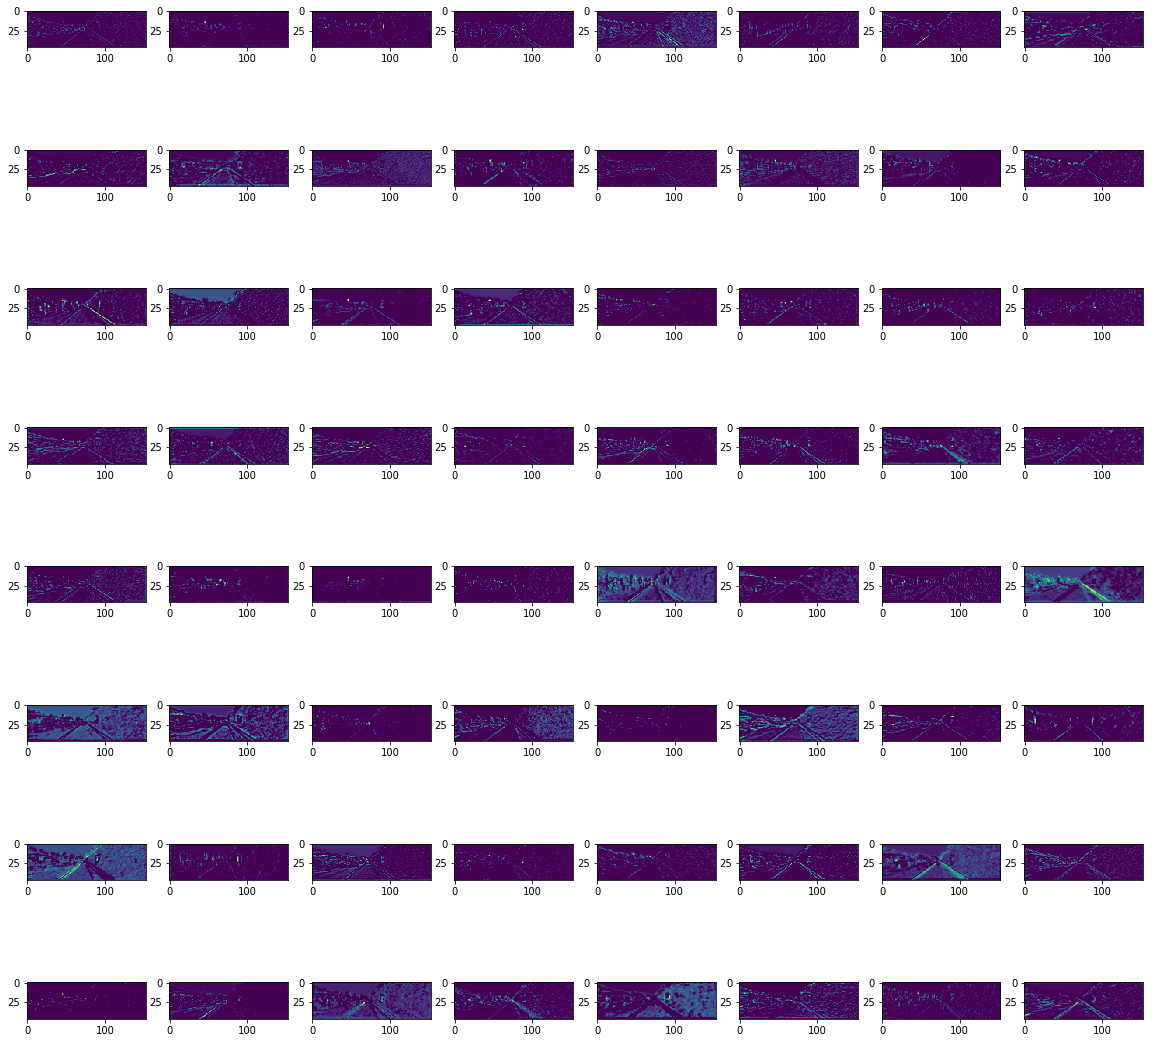

In [220]:

fig, axarr = plt.subplots(8, 8, sharex=True, sharey=True)
fig.set_figwidth(20)
fig.set_figheight(20)
c = 0
for i in range(8):
  for j in range(8):
    plt.subplot(8, 8, c+1)
    plt.imshow(rgb_res_groups2[1][0, :, :, c])
    c += 1
plt.show()

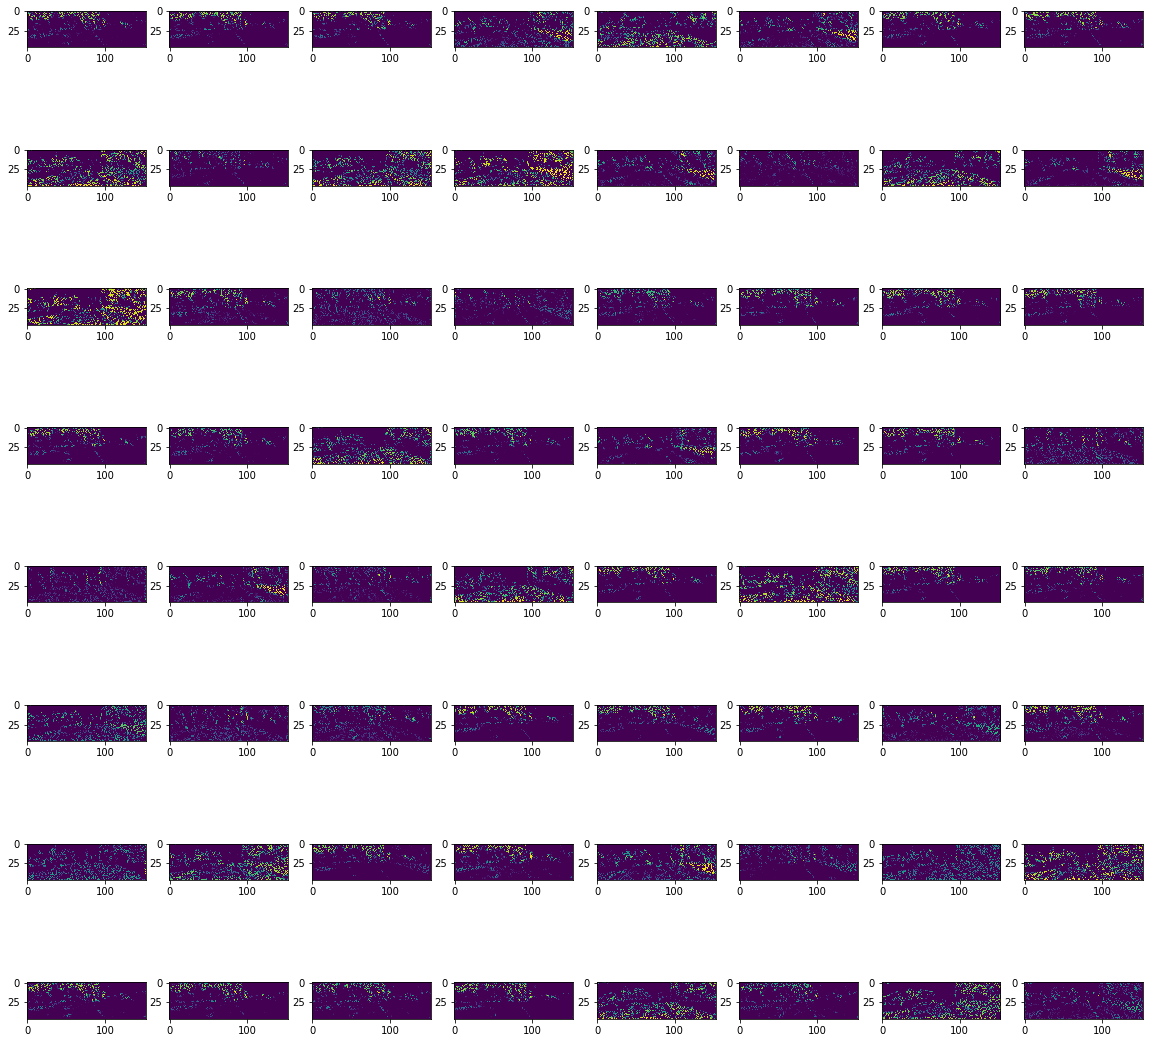

In [97]:

fig, axarr = plt.subplots(8, 8, sharex=True, sharey=True)
fig.set_figwidth(20)
fig.set_figheight(20)
c = 0
for i in range(8):
  for j in range(8):
    plt.subplot(8, 8, c+1)
    plt.imshow(rgb_res_groups2[1][0, :, :, c])
    c += 1
plt.show()

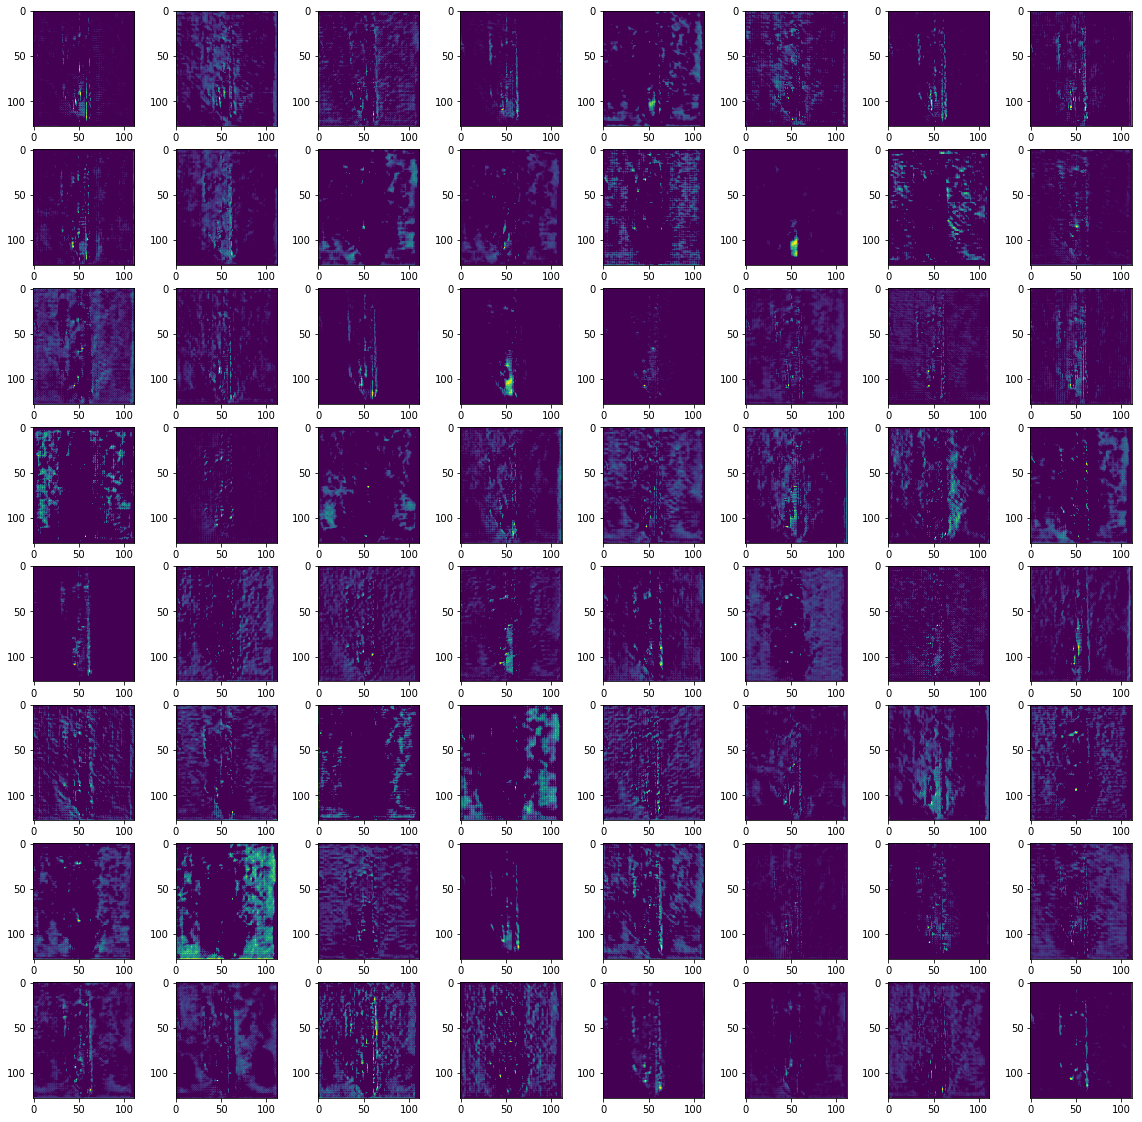

In [202]:
fig, axarr = plt.subplots(8, 8, sharex=True, sharey=True)
fig.set_figwidth(20)
fig.set_figheight(20)
c = 0
for i in range(8):
  for j in range(8):
    plt.subplot(8, 8, c+1)
    plt.imshow(debug_layers['fpn_lidar_output_post_conv_0'][0, :, :, c])
    c += 1
plt.show()

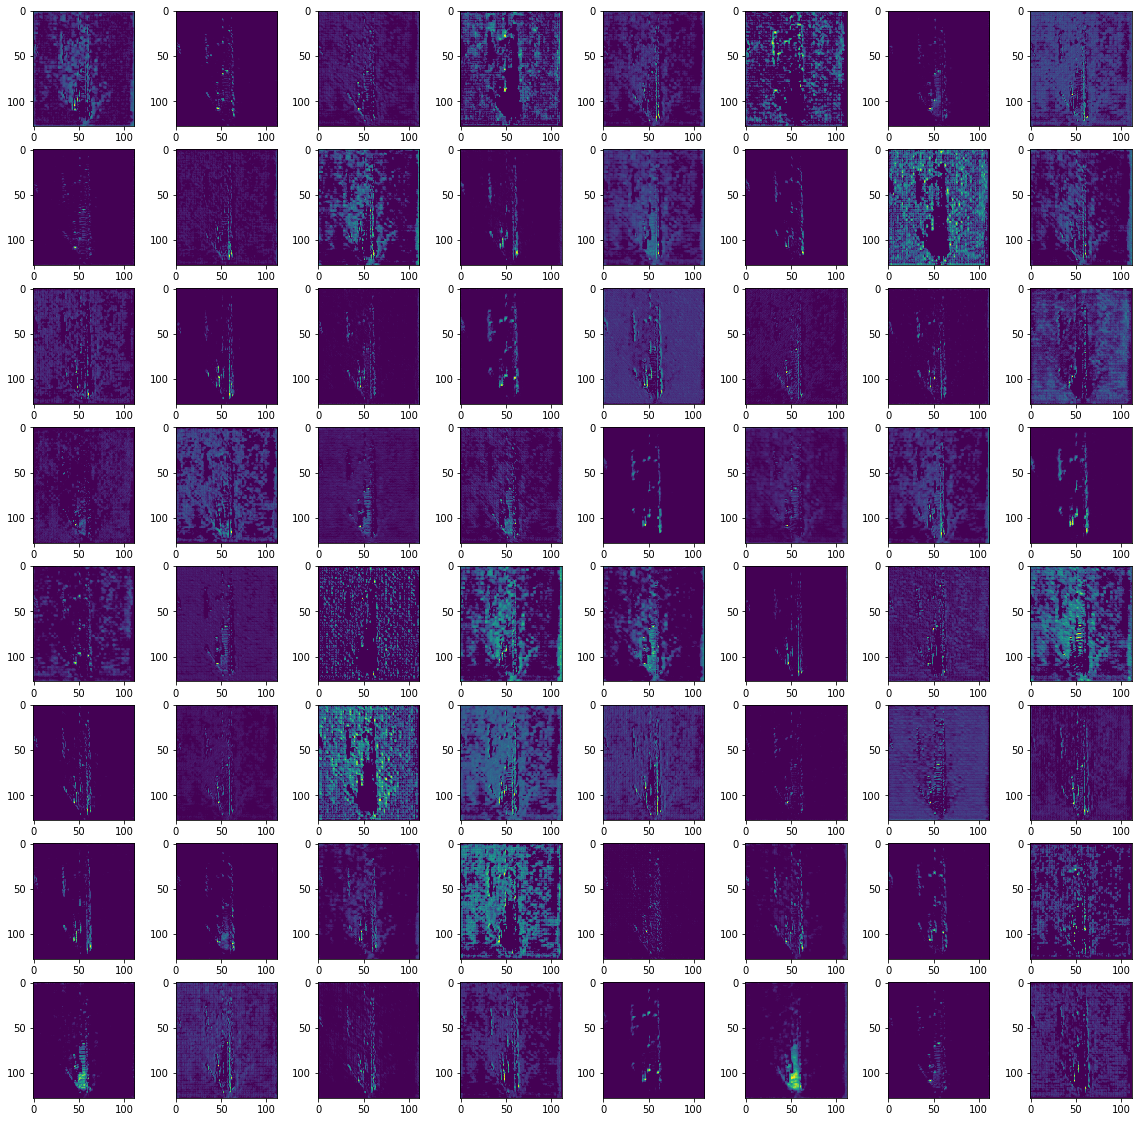

In [203]:
fig, axarr = plt.subplots(8, 8, sharex=True, sharey=True)
fig.set_figwidth(20)
fig.set_figheight(20)
c = 0
for i in range(8):
  for j in range(8):
    plt.subplot(8, 8, c+1)
    plt.imshow(debug_layers['fpn_lidar'][0][0, :, :, c])
    c += 1
plt.show()

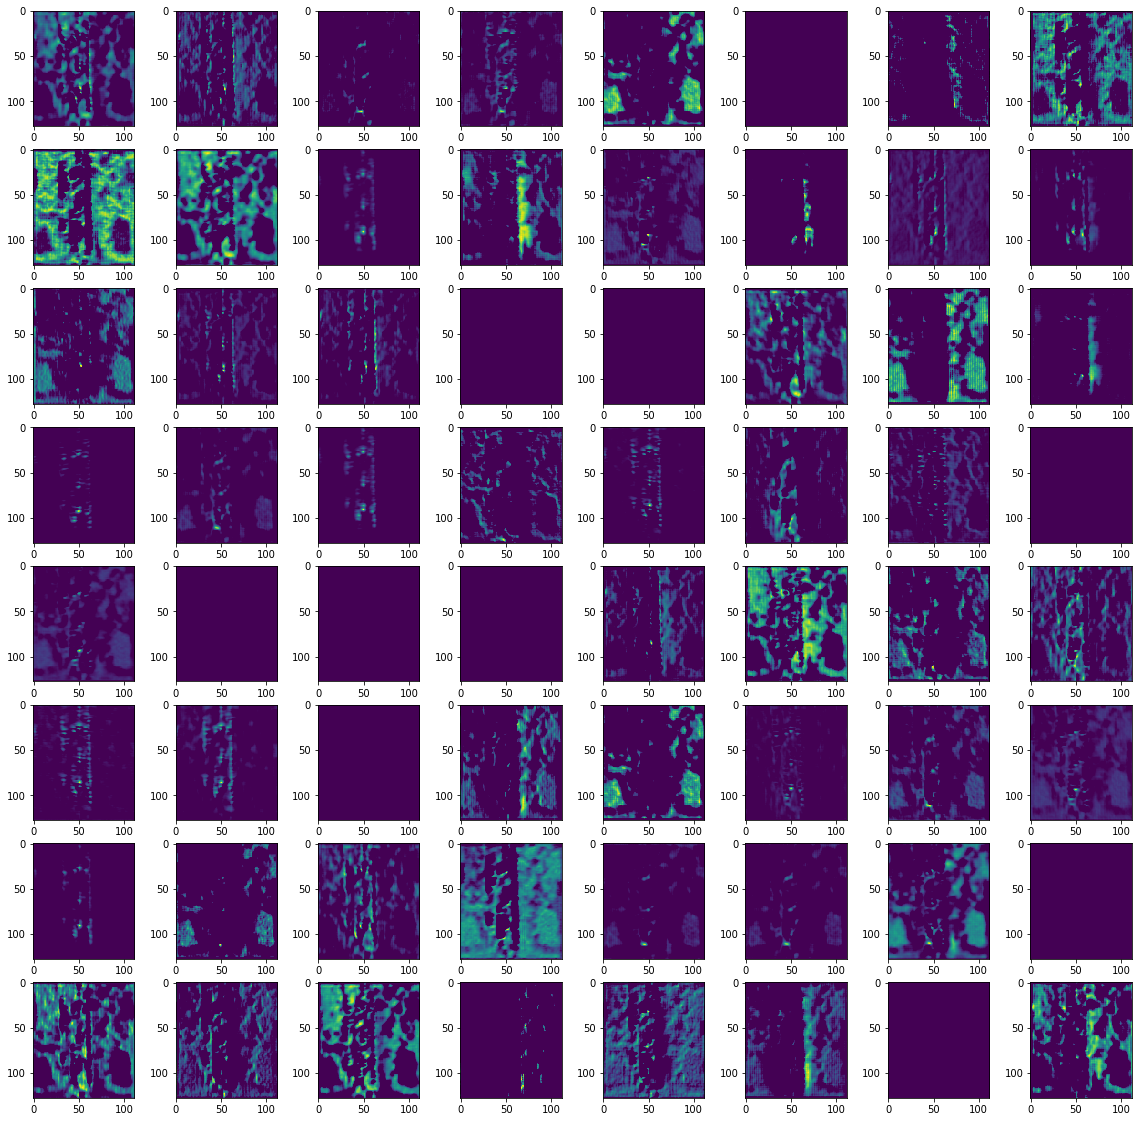

In [204]:
fig, axarr = plt.subplots(8, 8, sharex=True, sharey=True)
fig.set_figwidth(20)
fig.set_figheight(20)
c = 0
for i in range(8):
  for j in range(8):
    plt.subplot(8, 8, c+1)
    plt.imshow(debug_layers['fpn_lidar'][1][0, :, :, c])
    c += 1
plt.show()

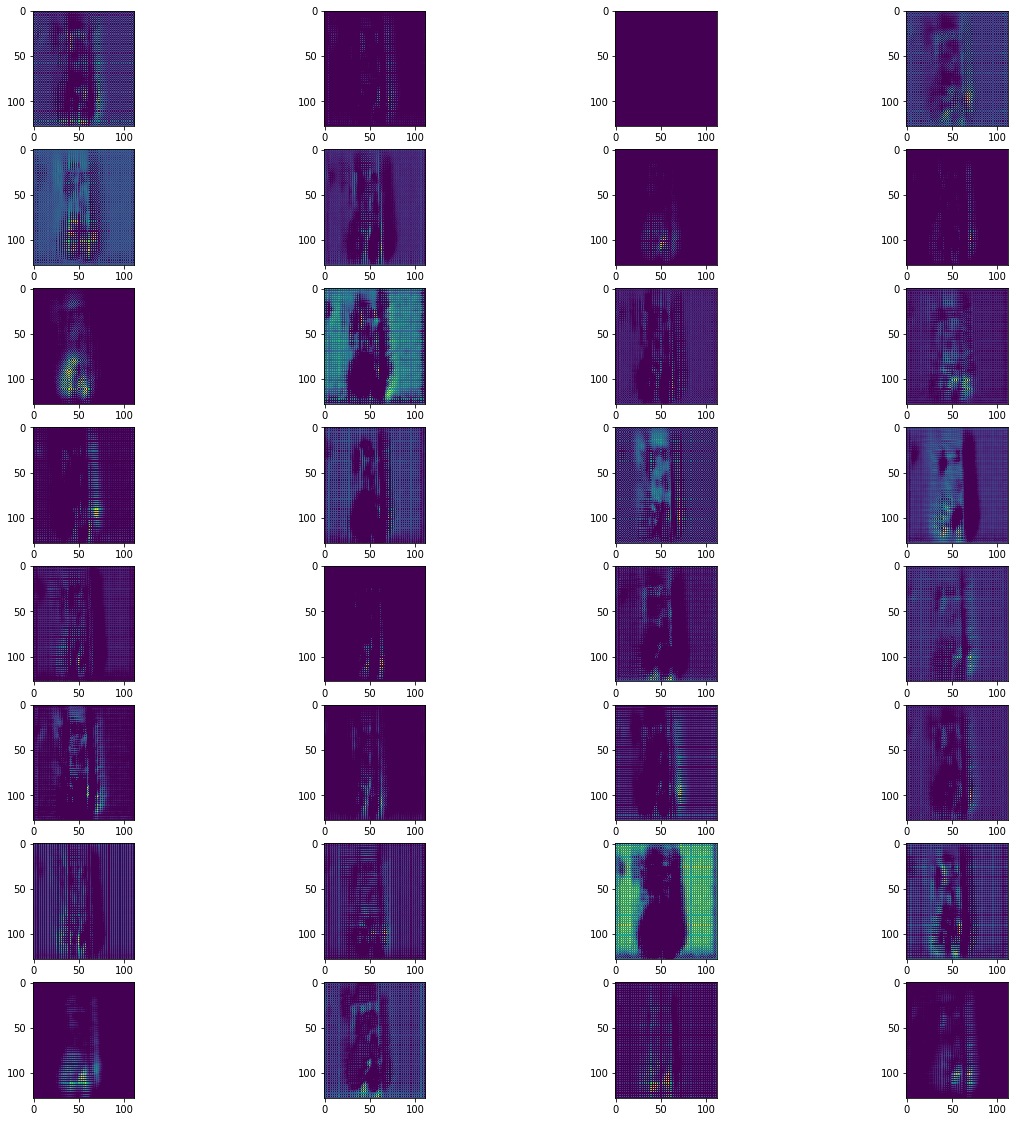

In [205]:
fig, axarr = plt.subplots(8, 4, sharex=True, sharey=True)
fig.set_figwidth(20)
fig.set_figheight(20)
c = 0
for i in range(8):
  for j in range(4):
    plt.subplot(8, 4, c+1)
    plt.imshow(debug_layers['fpn_lidar'][2][0, :, :, c])
    c += 1
plt.show()

In [206]:
res_groups[1].shape

(1, 128, 112, 128)

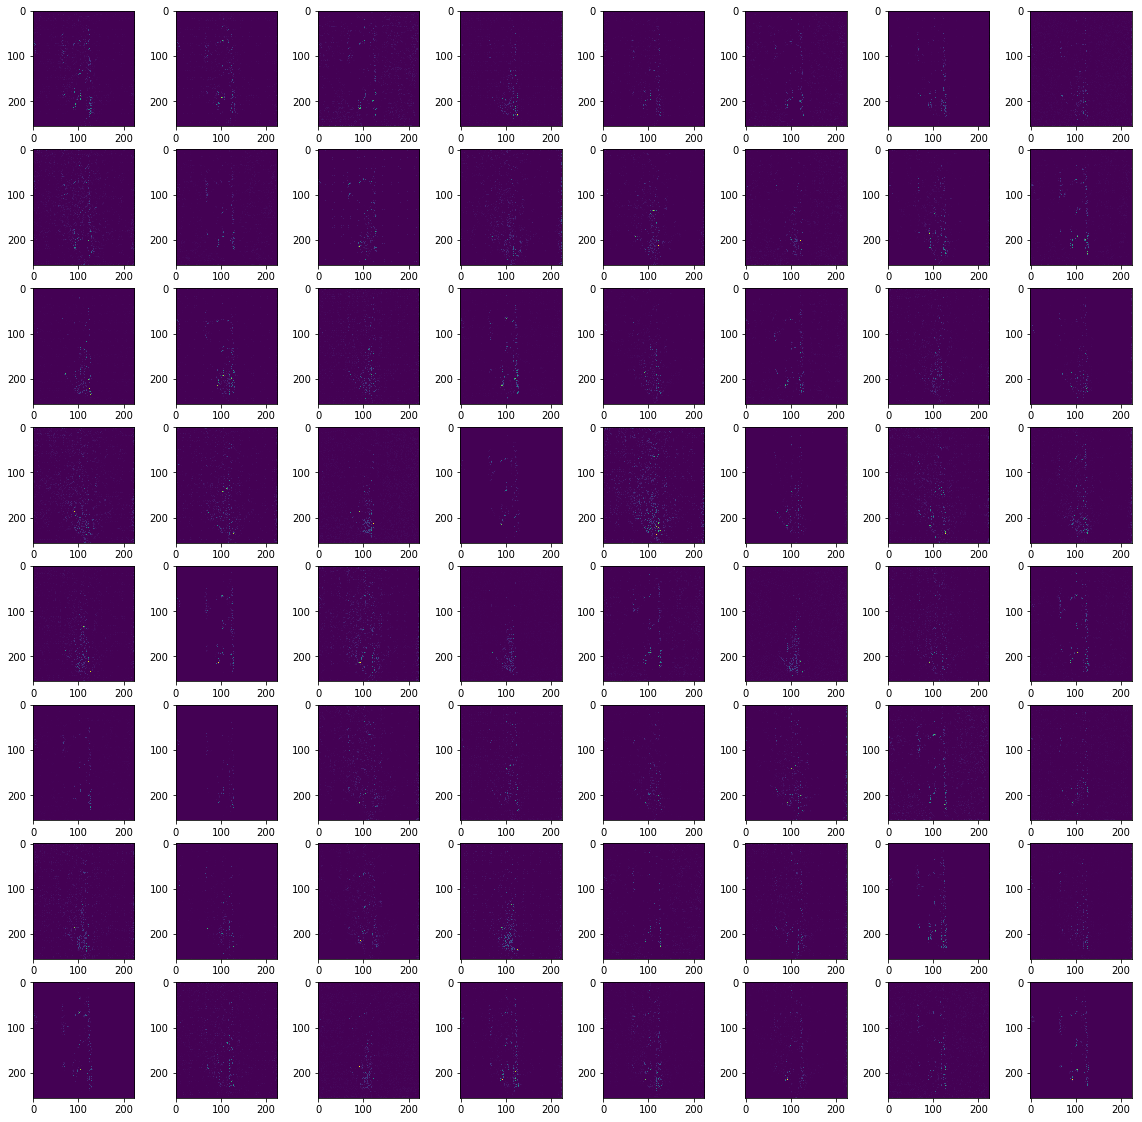

In [207]:
fig, axarr = plt.subplots(8, 8, sharex=True, sharey=True)
fig.set_figwidth(20)
fig.set_figheight(20)
c = 0
for i in range(8):
  for j in range(8):
    plt.subplot(8, 8, c+1)
    plt.imshow(res_groups2[0][0, :, :, c])
    c += 1
plt.show()

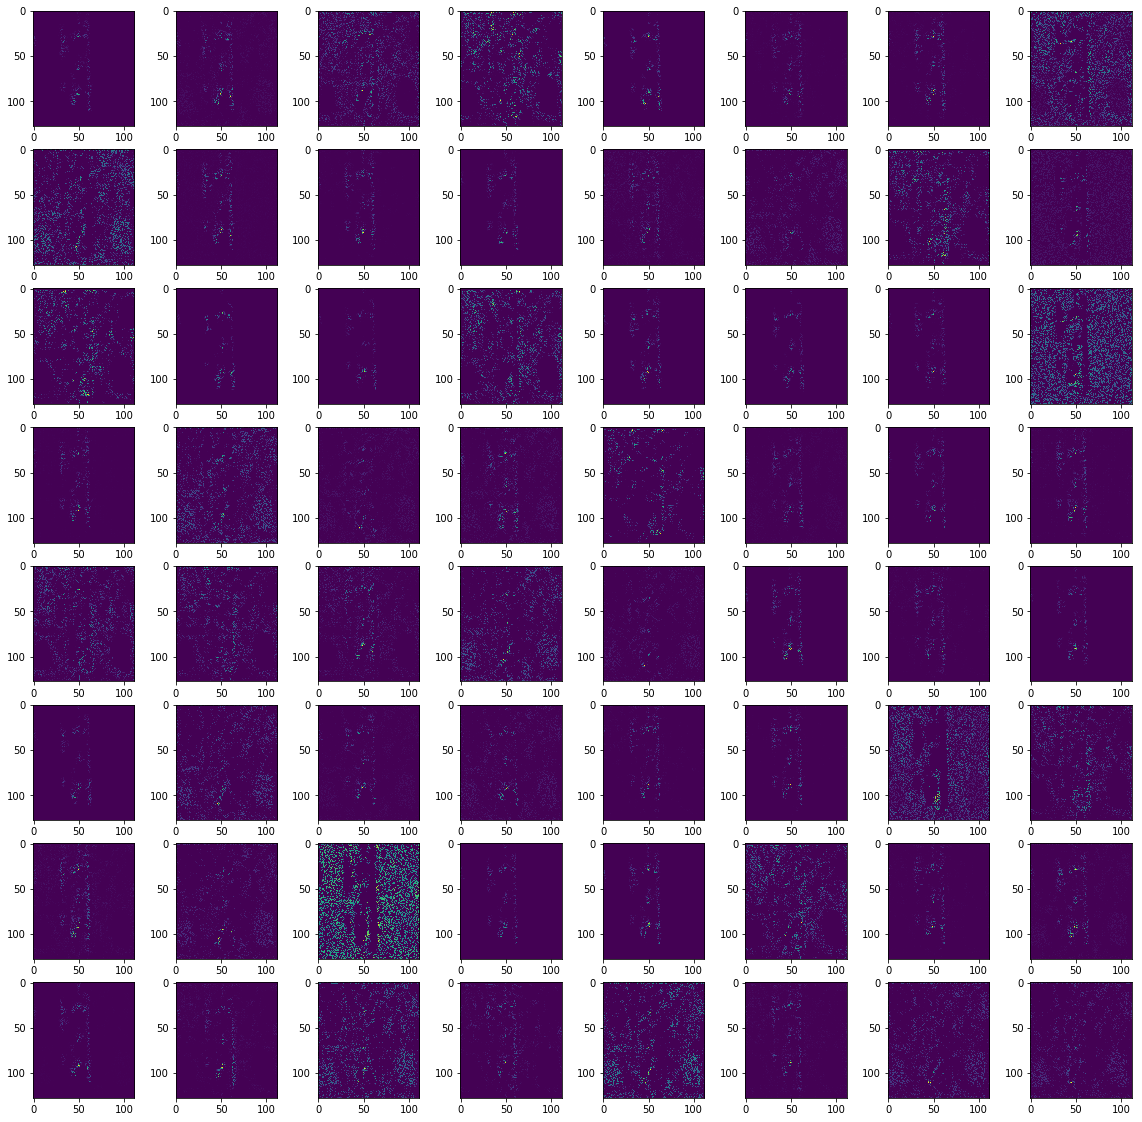

In [208]:
fig, axarr = plt.subplots(8, 8, sharex=True, sharey=True)
fig.set_figwidth(20)
fig.set_figheight(20)
c = 0
for i in range(8):
  for j in range(8):
    plt.subplot(8, 8, c+1)
    plt.imshow(res_groups2[1][0, :, :, c])
    c += 1
plt.show()

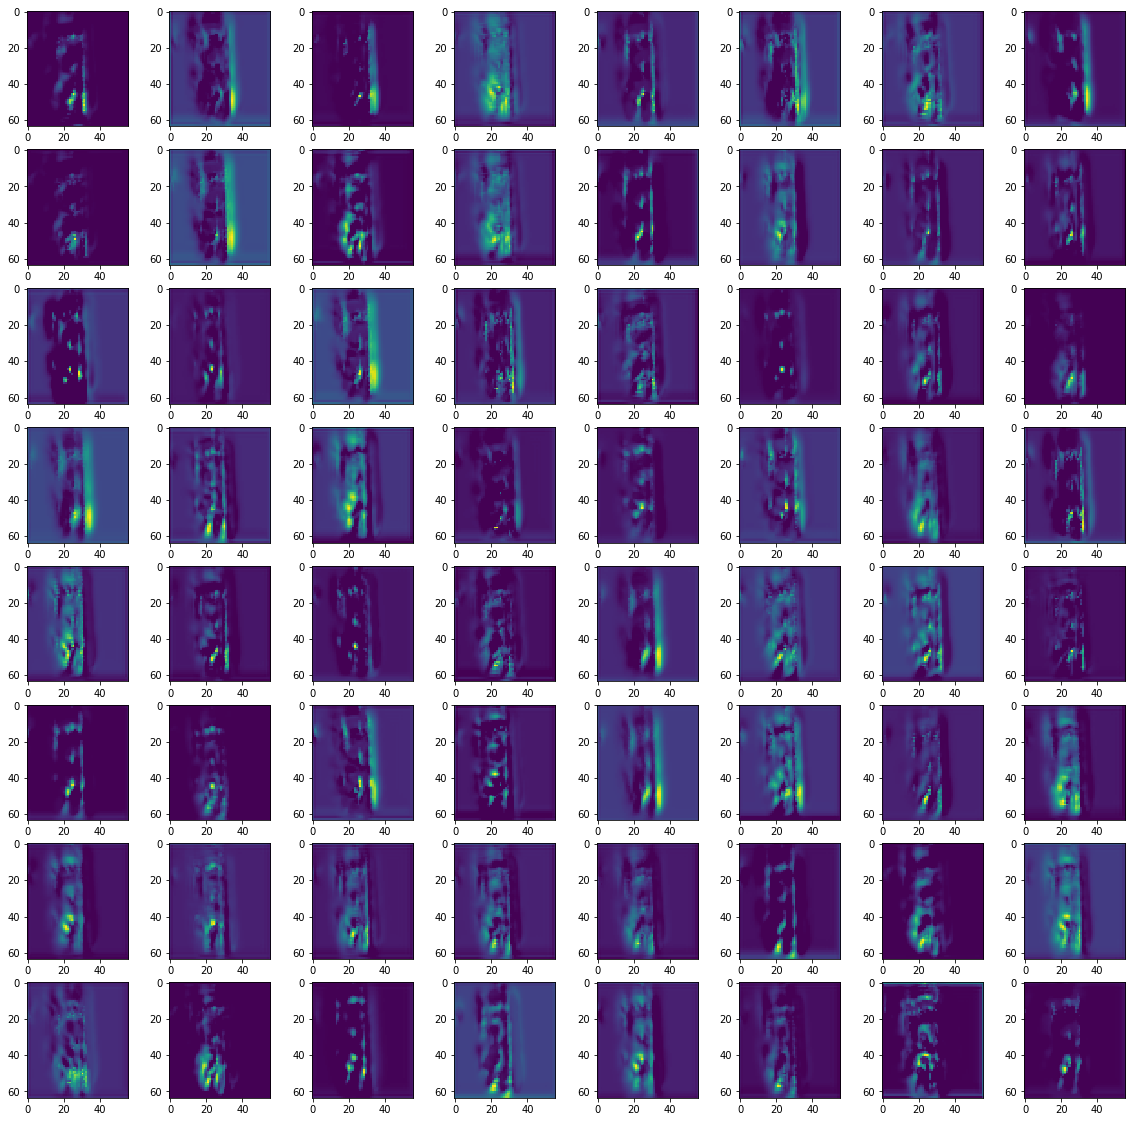

In [211]:
fig, axarr = plt.subplots(8, 8, sharex=True, sharey=True)
fig.set_figwidth(20)
fig.set_figheight(20)
c = 0
for i in range(8):
  for j in range(8):
    plt.subplot(8, 8, c+1)
    plt.imshow(res_groups[2][0, :, :, c])
    c += 1
plt.show()

In [210]:
# fig, axarr = plt.subplots(8, 8, sharex=True, sharey=True)
# fig.set_figwidth(20)
# fig.set_figheight(20)
# c = 0
# for i in range(8):
#   for j in range(8):
#     plt.subplot(8, 8, c+1)
#     plt.imshow(debug_layers['fpn_lidar_output_post_conv_0'][0, :, :, c])
#     c += 1
# plt.show()

In [102]:
# fig, axarr = plt.subplots(8, 8, sharex=True, sharey=True)
# fig.set_figwidth(20)
# fig.set_figheight(20)
# c = 0
# for i in range(8):
#   for j in range(8):
#     plt.subplot(8, 8, c+1)
#     plt.imshow(debug_layers['fpn_lidar_output_post_conv_1'][0, :, :, c])
#     c += 1
# plt.show()

In [67]:
# fig, axarr = plt.subplots(8, 8, sharex=True, sharey=True)
# fig.set_figwidth(20)
# fig.set_figheight(20)
# c = 0
# for i in range(8):
#   for j in range(8):
#     plt.subplot(8, 8, c+1)
#     plt.imshow(debug_layers['fpn_lidar_output_post_conv_2'][0, :, :, c])
#     c += 1
# plt.show()

In [ ]:
# fig, axarr = plt.subplots(8, 8, sharex=True, sharey=True)
# fig.set_figwidth(20)
# fig.set_figheight(20)
# c = 0
# for i in range(8):
#   for j in range(8):
#     plt.subplot(8, 8, c+1)
#     plt.imshow(debug_layers['fpn_lidar_output_post_conv_3'][0, :, :, c])
#     c += 1
# plt.show()